In [14]:
import pysindy as ps

import deepSI
from deepSI import System_data
from deepSI.fit_systems import SS_encoder_general
from deepSI.fit_systems.encoders import default_encoder_net, default_state_net, default_output_net
from deepSI.fit_systems.fit_system import My_Simple_DataLoader, print_array_byte_size, Tictoctimer
import torch
from torch import nn

import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from scipy.io import loadmat
import scipy.linalg as lin
import os

from utils import load_data
from data_processing import add_gaussian_noise

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import time
from copy import deepcopy
import itertools

import re

from feature_construction import feature_library
import polynomial as p
import fourier as f

from SI_SUBNET import SS_encoder_general_eq, h_identity, e_identity, simple_Linear
from SI_metrics import plot_coeff_grid, display_equation
from data_processing import plot_fft

import nonlinear_benchmarks

from scipy.signal import savgol_filter

*****LOAD DATA*****

In [ ]:
full = nonlinear_benchmarks.Silverbox(train_test_split=False)

train_val, test = nonlinear_benchmarks.Silverbox()
multisine_train_val = train_val
test_multisine_t, test_arrow_full, test_arrow_no_extrapolation = test

Nt, Nm, Na, Nae, N = train_val.y.shape[0], test_multisine_t.y.shape[0], test_arrow_full.y.shape[0], test_arrow_no_extrapolation.y.shape[0], full.y.shape[0]
Nt, Nm, Na, Nae, N

In [18]:
# e and h
train_eh    = System_data(u=train_val.u[:-1000], y=train_val.y[:-1000])
val_eh      = System_data(u=train_val.u[-1000:], y=train_val.y[-1000:])
arrow_full  = System_data(u=test_arrow_full.u, y=test_arrow_full.y)
test        = System_data(u=test_multisine_t.u, y=test_multisine_t.y)

In [19]:
train = train_eh
val = val_eh
test_arrow_full = arrow_full
test_multisine = test
arrow_next = System_data(u=test_arrow_full.u[:Nae], y=test_arrow_full.y[:Nae])

In [20]:
if len(test_arrow_full.y.shape)==1:
    T = np.array([[2/np.ptp(test_arrow_full.y, axis=0),0],[0,1]])
else:
    T = np.diag(2/np.ptp(test_arrow_full.y, axis=0))

U = 1/np.ptp(test_arrow_full.u)*np.eye(1)

In [21]:
train_set = T[0,0]*train.y
val_set   = T[0,0]*val.y
taf_set   = T[0,0]*test_arrow_full.y
tm_set    = T[0,0]*test_multisine.y
tae_set   = T[0,0]*arrow_next.y

In [22]:
train           = System_data(u=U[0]*train.u, y=train_set)
val             = System_data(u=U[0]*val.u, y=val_set)
test_arrow_full = System_data(u=U[0]*test_arrow_full.u, y=taf_set)
test_multisine  = System_data(u=U[0]*test_multisine.u, y=tm_set)
test_arrow_no_extrapolation = System_data(u=U[0]*arrow_next.u, y=tae_set)

*****SPECIFY FUNCTIONS TO BE CONSIDERED*****

In [23]:
# functions = [p.f, p.f2, p.f3, p.f5, f.sin, f.cos, f.sin2x, f.cos2x, f.sin3x, f.cos3x, f.sin4x, f.cos4x, f.sin5x, f.cos5x]# p.f6, p.f7, p.f8, p.f9, p.f10, p.f11, p.f12, p.f13, p.f14, p.f15, p.f16, p.f17, p.f18, p.f19, p.f20]
# functions = [p.f, f.sin, f.cos, f.sin2x, f.cos2x, f.sin3x, f.cos3x, f.sin4x, f.cos4x, f.sin5x, f.cos5x, f.sin6x, f.cos6x, f.sin7x, f.cos7x, f.sin8x, f.cos8x, f.sin9x, f.cos9x, f.sin10x, f.cos10x]#,\
            #   f.sin11x, f.cos11x, f.sin12x, f.cos12x, f.sin13x, f.cos13x, f.sin14x, f.cos14x, f.sin15x, f.cos15x, f.sin16x, f.cos16x, f.sin17x, f.cos17x, f.sin18x, f.cos18x, f.sin19x, f.cos19x, f.sin20x, f.cos20x]
functions = [p.f, p.f2, p.f3]
poly = feature_library(functions=functions, nx=2, nu=1, T=T, U=U)

*****INITIALIZE NETWORK*****

In [24]:
batch_size = 256

# network param
nx, nu = 2, 1 # state dimension and inputs
na, nb = 0, 0
na_right = 1

f_net_kwargs = {"feature_library": poly, "u": nu, "nf": poly.feature_number()}

# output model
h_net = h_identity
h_net_kwargs = {}

# encoder model
e_net = e_identity
e_net_kwargs = {}

fit_sys = SS_encoder_general_eq(nx=nx, na=na, nb=nb, na_right=na_right,\
                                    f_net_kwargs=f_net_kwargs)

In [25]:
nf = 1

# regularization
gamma = 1e-3
mode = None
T_idx = None

# pruning
pruning = False
pruning_mode = "RMS"
epo_idx = 15
threshold = 1e-2

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, pruning_mode=pruning_mode, threshold=threshold, epo_idx=epo_idx)

fit_sys.fit(train, val, epochs=500, batch_size = 256, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

 55%|█████▍    | 273/500 [06:52<06:14,  1.65s/it]

Epoch  273, sqrt loss  0.1085, Val sim-NRMS 0.9077, Time Loss: 74.6%, data: 1.8%, val: 23.2%, 165.3 batches/sec


 55%|█████▍    | 274/500 [06:54<06:11,  1.64s/it]

Epoch  274, sqrt loss  0.1086, Val sim-NRMS 0.9079, Time Loss: 74.6%, data: 1.8%, val: 23.2%, 165.3 batches/sec


 55%|█████▌    | 275/500 [06:56<06:10,  1.65s/it]

Epoch  275, sqrt loss  0.1086, Val sim-NRMS 0.9059, Time Loss: 74.7%, data: 1.8%, val: 23.2%, 165.2 batches/sec


 55%|█████▌    | 276/500 [06:57<06:08,  1.65s/it]

Epoch  276, sqrt loss  0.1087, Val sim-NRMS  0.905, Time Loss: 74.7%, data: 1.8%, val: 23.1%, 165.2 batches/sec


 55%|█████▌    | 277/500 [06:59<06:08,  1.65s/it]

Epoch  277, sqrt loss  0.1089, Val sim-NRMS 0.9059, Time Loss: 74.7%, data: 1.8%, val: 23.1%, 165.1 batches/sec


 56%|█████▌    | 278/500 [07:01<06:09,  1.66s/it]

Epoch  278, sqrt loss  0.1088, Val sim-NRMS 0.9083, Time Loss: 74.7%, data: 1.8%, val: 23.1%, 165.0 batches/sec


 56%|█████▌    | 279/500 [07:02<06:08,  1.67s/it]

Epoch  279, sqrt loss  0.1088, Val sim-NRMS 0.9072, Time Loss: 74.7%, data: 1.8%, val: 23.1%, 165.0 batches/sec


 56%|█████▌    | 280/500 [07:04<06:02,  1.65s/it]

Epoch  280, sqrt loss  0.1088, Val sim-NRMS 0.9075, Time Loss: 74.8%, data: 1.8%, val: 23.1%, 164.9 batches/sec


 56%|█████▌    | 281/500 [07:05<05:58,  1.63s/it]

Epoch  281, sqrt loss   0.109, Val sim-NRMS 0.9088, Time Loss: 74.8%, data: 1.8%, val: 23.0%, 164.9 batches/sec


 56%|█████▋    | 282/500 [07:07<05:56,  1.63s/it]

Epoch  282, sqrt loss  0.1091, Val sim-NRMS 0.9075, Time Loss: 74.8%, data: 1.8%, val: 23.0%, 164.9 batches/sec


 57%|█████▋    | 283/500 [07:09<05:55,  1.64s/it]

Epoch  283, sqrt loss   0.109, Val sim-NRMS 0.9069, Time Loss: 74.8%, data: 1.8%, val: 23.0%, 164.8 batches/sec


 57%|█████▋    | 284/500 [07:10<05:53,  1.64s/it]

Epoch  284, sqrt loss  0.1091, Val sim-NRMS 0.9073, Time Loss: 74.8%, data: 1.8%, val: 23.0%, 164.8 batches/sec


 57%|█████▋    | 285/500 [07:12<05:55,  1.65s/it]

Epoch  285, sqrt loss  0.1092, Val sim-NRMS 0.9137, Time Loss: 74.9%, data: 1.8%, val: 22.9%, 164.7 batches/sec


 57%|█████▋    | 286/500 [07:14<05:52,  1.65s/it]

Epoch  286, sqrt loss  0.1091, Val sim-NRMS 0.9085, Time Loss: 74.9%, data: 1.8%, val: 22.9%, 164.7 batches/sec


 57%|█████▋    | 287/500 [07:15<05:52,  1.65s/it]

Epoch  287, sqrt loss  0.1092, Val sim-NRMS 0.9061, Time Loss: 74.9%, data: 1.8%, val: 22.9%, 164.6 batches/sec


 58%|█████▊    | 288/500 [07:17<05:49,  1.65s/it]

Epoch  288, sqrt loss  0.1092, Val sim-NRMS 0.9078, Time Loss: 74.9%, data: 1.8%, val: 22.9%, 164.6 batches/sec


 58%|█████▊    | 289/500 [07:19<05:48,  1.65s/it]

Epoch  289, sqrt loss  0.1092, Val sim-NRMS 0.9081, Time Loss: 75.0%, data: 1.8%, val: 22.9%, 164.5 batches/sec


 58%|█████▊    | 290/500 [07:20<05:47,  1.65s/it]

Epoch  290, sqrt loss  0.1092, Val sim-NRMS 0.9082, Time Loss: 75.0%, data: 1.8%, val: 22.8%, 164.5 batches/sec


 58%|█████▊    | 291/500 [07:22<05:46,  1.66s/it]

Epoch  291, sqrt loss  0.1093, Val sim-NRMS 0.9072, Time Loss: 75.0%, data: 1.8%, val: 22.8%, 164.4 batches/sec


 58%|█████▊    | 292/500 [07:24<05:46,  1.66s/it]

Epoch  292, sqrt loss  0.1093, Val sim-NRMS  0.909, Time Loss: 75.0%, data: 1.8%, val: 22.8%, 164.3 batches/sec


 59%|█████▊    | 293/500 [07:25<05:42,  1.66s/it]

Epoch  293, sqrt loss  0.1093, Val sim-NRMS 0.9086, Time Loss: 75.0%, data: 1.8%, val: 22.8%, 164.3 batches/sec


 59%|█████▉    | 294/500 [07:27<05:40,  1.65s/it]

Epoch  294, sqrt loss  0.1093, Val sim-NRMS 0.9099, Time Loss: 75.1%, data: 1.8%, val: 22.8%, 164.2 batches/sec


 59%|█████▉    | 295/500 [07:29<05:41,  1.66s/it]

Epoch  295, sqrt loss  0.1093, Val sim-NRMS 0.9092, Time Loss: 75.1%, data: 1.8%, val: 22.7%, 164.2 batches/sec


 59%|█████▉    | 296/500 [07:30<05:38,  1.66s/it]

Epoch  296, sqrt loss  0.1093, Val sim-NRMS 0.9077, Time Loss: 75.1%, data: 1.8%, val: 22.7%, 164.1 batches/sec


 59%|█████▉    | 297/500 [07:32<05:36,  1.66s/it]

Epoch  297, sqrt loss  0.1092, Val sim-NRMS 0.9087, Time Loss: 75.1%, data: 1.8%, val: 22.7%, 164.1 batches/sec


 60%|█████▉    | 298/500 [07:34<05:34,  1.65s/it]

Epoch  298, sqrt loss  0.1092, Val sim-NRMS 0.9094, Time Loss: 75.2%, data: 1.8%, val: 22.7%, 164.1 batches/sec


 60%|█████▉    | 299/500 [07:35<05:29,  1.64s/it]

Epoch  299, sqrt loss  0.1094, Val sim-NRMS 0.9096, Time Loss: 75.2%, data: 1.8%, val: 22.7%, 164.0 batches/sec


 60%|██████    | 300/500 [07:37<05:29,  1.65s/it]

Epoch  300, sqrt loss  0.1094, Val sim-NRMS 0.9089, Time Loss: 75.2%, data: 1.8%, val: 22.7%, 164.0 batches/sec


 60%|██████    | 301/500 [07:39<05:29,  1.66s/it]

Epoch  301, sqrt loss  0.1096, Val sim-NRMS  0.914, Time Loss: 75.2%, data: 1.8%, val: 22.6%, 163.9 batches/sec


 60%|██████    | 302/500 [07:40<05:28,  1.66s/it]

Epoch  302, sqrt loss  0.1097, Val sim-NRMS 0.9095, Time Loss: 75.2%, data: 1.8%, val: 22.6%, 163.9 batches/sec


 61%|██████    | 303/500 [07:42<05:28,  1.67s/it]

Epoch  303, sqrt loss  0.1097, Val sim-NRMS 0.9099, Time Loss: 75.3%, data: 1.8%, val: 22.6%, 163.8 batches/sec


 61%|██████    | 304/500 [07:44<05:27,  1.67s/it]

Epoch  304, sqrt loss  0.1097, Val sim-NRMS 0.9092, Time Loss: 75.3%, data: 1.8%, val: 22.6%, 163.8 batches/sec


 61%|██████    | 305/500 [07:45<05:25,  1.67s/it]

Epoch  305, sqrt loss  0.1098, Val sim-NRMS 0.9094, Time Loss: 75.3%, data: 1.8%, val: 22.6%, 163.7 batches/sec


 61%|██████    | 306/500 [07:47<05:21,  1.66s/it]

Epoch  306, sqrt loss  0.1098, Val sim-NRMS 0.9093, Time Loss: 75.3%, data: 1.8%, val: 22.5%, 163.7 batches/sec


 61%|██████▏   | 307/500 [07:49<05:20,  1.66s/it]

Epoch  307, sqrt loss  0.1099, Val sim-NRMS   0.91, Time Loss: 75.3%, data: 1.8%, val: 22.5%, 163.6 batches/sec


 62%|██████▏   | 308/500 [07:50<05:24,  1.69s/it]

Epoch  308, sqrt loss  0.1098, Val sim-NRMS 0.9097, Time Loss: 75.4%, data: 1.8%, val: 22.5%, 163.5 batches/sec


 62%|██████▏   | 309/500 [07:52<05:21,  1.68s/it]

Epoch  309, sqrt loss  0.1101, Val sim-NRMS 0.9087, Time Loss: 75.4%, data: 1.8%, val: 22.5%, 163.5 batches/sec


 62%|██████▏   | 310/500 [07:54<05:17,  1.67s/it]

Epoch  310, sqrt loss  0.1101, Val sim-NRMS  0.912, Time Loss: 75.4%, data: 1.8%, val: 22.5%, 163.5 batches/sec


 62%|██████▏   | 311/500 [07:55<05:16,  1.67s/it]

Epoch  311, sqrt loss    0.11, Val sim-NRMS  0.911, Time Loss: 75.4%, data: 1.8%, val: 22.4%, 163.4 batches/sec


 62%|██████▏   | 312/500 [07:57<05:14,  1.67s/it]

Epoch  312, sqrt loss  0.1102, Val sim-NRMS 0.9108, Time Loss: 75.4%, data: 1.8%, val: 22.4%, 163.4 batches/sec


 63%|██████▎   | 313/500 [07:59<05:12,  1.67s/it]

Epoch  313, sqrt loss  0.1102, Val sim-NRMS 0.9103, Time Loss: 75.4%, data: 1.8%, val: 22.4%, 163.3 batches/sec


 63%|██████▎   | 314/500 [08:00<05:12,  1.68s/it]

Epoch  314, sqrt loss    0.11, Val sim-NRMS 0.9107, Time Loss: 75.5%, data: 1.8%, val: 22.4%, 163.2 batches/sec


 63%|██████▎   | 315/500 [08:02<05:10,  1.68s/it]

Epoch  315, sqrt loss    0.11, Val sim-NRMS 0.9116, Time Loss: 75.5%, data: 1.8%, val: 22.4%, 163.2 batches/sec


 63%|██████▎   | 316/500 [08:04<05:09,  1.68s/it]

Epoch  316, sqrt loss    0.11, Val sim-NRMS 0.9105, Time Loss: 75.5%, data: 1.8%, val: 22.4%, 163.1 batches/sec


 63%|██████▎   | 317/500 [08:05<05:06,  1.67s/it]

Epoch  317, sqrt loss  0.1101, Val sim-NRMS 0.9126, Time Loss: 75.5%, data: 1.8%, val: 22.3%, 163.1 batches/sec


 64%|██████▎   | 318/500 [08:07<05:04,  1.67s/it]

Epoch  318, sqrt loss  0.1102, Val sim-NRMS 0.9102, Time Loss: 75.5%, data: 1.8%, val: 22.3%, 163.1 batches/sec


 64%|██████▍   | 319/500 [08:09<05:05,  1.69s/it]

Epoch  319, sqrt loss  0.1102, Val sim-NRMS 0.9185, Time Loss: 75.5%, data: 1.8%, val: 22.3%, 163.0 batches/sec


 64%|██████▍   | 320/500 [08:10<05:04,  1.69s/it]

Epoch  320, sqrt loss  0.1102, Val sim-NRMS 0.9123, Time Loss: 75.6%, data: 1.8%, val: 22.3%, 162.9 batches/sec


 64%|██████▍   | 321/500 [08:12<05:04,  1.70s/it]

Epoch  321, sqrt loss  0.1101, Val sim-NRMS 0.9123, Time Loss: 75.6%, data: 1.8%, val: 22.3%, 162.9 batches/sec


 64%|██████▍   | 322/500 [08:14<05:02,  1.70s/it]

Epoch  322, sqrt loss  0.1102, Val sim-NRMS 0.9123, Time Loss: 75.6%, data: 1.8%, val: 22.3%, 162.8 batches/sec


 65%|██████▍   | 323/500 [08:16<04:59,  1.69s/it]

Epoch  323, sqrt loss  0.1102, Val sim-NRMS 0.9122, Time Loss: 75.6%, data: 1.8%, val: 22.2%, 162.8 batches/sec


 65%|██████▍   | 324/500 [08:17<04:57,  1.69s/it]

Epoch  324, sqrt loss  0.1103, Val sim-NRMS 0.9141, Time Loss: 75.6%, data: 1.8%, val: 22.2%, 162.7 batches/sec


 65%|██████▌   | 325/500 [08:19<04:57,  1.70s/it]

Epoch  325, sqrt loss  0.1105, Val sim-NRMS 0.9141, Time Loss: 75.7%, data: 1.8%, val: 22.2%, 162.7 batches/sec


 65%|██████▌   | 326/500 [08:21<04:56,  1.70s/it]

Epoch  326, sqrt loss  0.1104, Val sim-NRMS 0.9144, Time Loss: 75.7%, data: 1.8%, val: 22.2%, 162.6 batches/sec


 65%|██████▌   | 327/500 [08:22<04:57,  1.72s/it]

Epoch  327, sqrt loss  0.1104, Val sim-NRMS 0.9136, Time Loss: 75.7%, data: 1.8%, val: 22.2%, 162.5 batches/sec


 66%|██████▌   | 328/500 [08:24<04:54,  1.71s/it]

Epoch  328, sqrt loss  0.1106, Val sim-NRMS 0.9118, Time Loss: 75.7%, data: 1.8%, val: 22.2%, 162.5 batches/sec


 66%|██████▌   | 329/500 [08:26<04:50,  1.70s/it]

Epoch  329, sqrt loss  0.1106, Val sim-NRMS 0.9142, Time Loss: 75.7%, data: 1.8%, val: 22.1%, 162.5 batches/sec


 66%|██████▌   | 330/500 [08:28<04:49,  1.70s/it]

Epoch  330, sqrt loss  0.1108, Val sim-NRMS 0.9139, Time Loss: 75.7%, data: 1.8%, val: 22.1%, 162.4 batches/sec


 66%|██████▌   | 331/500 [08:29<04:47,  1.70s/it]

Epoch  331, sqrt loss  0.1108, Val sim-NRMS 0.9155, Time Loss: 75.8%, data: 1.8%, val: 22.1%, 162.3 batches/sec


 66%|██████▋   | 332/500 [08:31<04:47,  1.71s/it]

Epoch  332, sqrt loss  0.1108, Val sim-NRMS 0.9148, Time Loss: 75.8%, data: 1.8%, val: 22.1%, 162.3 batches/sec


 67%|██████▋   | 333/500 [08:33<04:46,  1.72s/it]

Epoch  333, sqrt loss  0.1109, Val sim-NRMS 0.9149, Time Loss: 75.8%, data: 1.8%, val: 22.1%, 162.2 batches/sec


 67%|██████▋   | 334/500 [08:34<04:45,  1.72s/it]

Epoch  334, sqrt loss   0.111, Val sim-NRMS 0.9142, Time Loss: 75.8%, data: 1.8%, val: 22.1%, 162.2 batches/sec


 67%|██████▋   | 335/500 [08:36<04:43,  1.72s/it]

Epoch  335, sqrt loss  0.1111, Val sim-NRMS 0.9131, Time Loss: 75.8%, data: 1.8%, val: 22.0%, 162.1 batches/sec


 67%|██████▋   | 336/500 [08:38<04:42,  1.72s/it]

Epoch  336, sqrt loss  0.1111, Val sim-NRMS 0.9137, Time Loss: 75.9%, data: 1.8%, val: 22.0%, 162.1 batches/sec


 67%|██████▋   | 337/500 [08:40<04:42,  1.73s/it]

Epoch  337, sqrt loss  0.1112, Val sim-NRMS 0.9142, Time Loss: 75.9%, data: 1.8%, val: 22.0%, 162.0 batches/sec


 68%|██████▊   | 338/500 [08:41<04:40,  1.73s/it]

Epoch  338, sqrt loss  0.1111, Val sim-NRMS 0.9146, Time Loss: 75.9%, data: 1.8%, val: 22.0%, 161.9 batches/sec


 68%|██████▊   | 339/500 [08:43<04:38,  1.73s/it]

Epoch  339, sqrt loss  0.1111, Val sim-NRMS 0.9141, Time Loss: 75.9%, data: 1.8%, val: 22.0%, 161.9 batches/sec


 68%|██████▊   | 340/500 [08:45<04:36,  1.73s/it]

Epoch  340, sqrt loss  0.1112, Val sim-NRMS 0.9136, Time Loss: 75.9%, data: 1.8%, val: 21.9%, 161.8 batches/sec


 68%|██████▊   | 341/500 [08:47<04:34,  1.73s/it]

Epoch  341, sqrt loss  0.1115, Val sim-NRMS 0.9146, Time Loss: 75.9%, data: 1.8%, val: 21.9%, 161.8 batches/sec


 68%|██████▊   | 342/500 [08:48<04:30,  1.71s/it]

Epoch  342, sqrt loss  0.1115, Val sim-NRMS 0.9155, Time Loss: 76.0%, data: 1.8%, val: 21.9%, 161.7 batches/sec


 69%|██████▊   | 343/500 [08:50<04:29,  1.71s/it]

Epoch  343, sqrt loss  0.1115, Val sim-NRMS 0.9146, Time Loss: 76.0%, data: 1.8%, val: 21.9%, 161.7 batches/sec


 69%|██████▉   | 344/500 [08:52<04:27,  1.71s/it]

Epoch  344, sqrt loss  0.1115, Val sim-NRMS 0.9156, Time Loss: 76.0%, data: 1.8%, val: 21.9%, 161.6 batches/sec


 69%|██████▉   | 345/500 [08:53<04:24,  1.71s/it]

Epoch  345, sqrt loss  0.1116, Val sim-NRMS  0.915, Time Loss: 76.0%, data: 1.8%, val: 21.9%, 161.6 batches/sec


 69%|██████▉   | 346/500 [08:55<04:23,  1.71s/it]

Epoch  346, sqrt loss  0.1116, Val sim-NRMS 0.9161, Time Loss: 76.0%, data: 1.8%, val: 21.8%, 161.5 batches/sec


 69%|██████▉   | 347/500 [08:57<04:23,  1.72s/it]

Epoch  347, sqrt loss  0.1116, Val sim-NRMS 0.9145, Time Loss: 76.0%, data: 1.8%, val: 21.8%, 161.5 batches/sec


 70%|██████▉   | 348/500 [08:58<04:21,  1.72s/it]

Epoch  348, sqrt loss  0.1116, Val sim-NRMS 0.9167, Time Loss: 76.1%, data: 1.8%, val: 21.8%, 161.4 batches/sec


 70%|██████▉   | 348/500 [09:00<03:56,  1.55s/it]


Stopping early due to a KeyboardInterrupt


In [27]:
nf = 5

# regularization
gamma = 1e-3
mode = None
T_idx = None

# pruning
pruning = False
pruning_mode = "RMS"
epo_idx = 15
threshold = 1e-2

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, pruning_mode=pruning_mode, threshold=threshold, epo_idx=epo_idx)

fit_sys.fit(train, val, epochs=200, batch_size = 256, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  6.4 MB
N_training_samples = 64057, batch_size = 256, N_batch_updates_per_epoch = 250
Initial Validation sim-NRMS= 0.1381390060280389


  1%|          | 1/100 [00:04<07:26,  4.51s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13688176860990203
Epoch    1, sqrt loss  0.1286, Val sim-NRMS 0.1369, Time Loss: 67.1%, data: 0.7%, val: 32.1%, 55.4 batches/sec


  2%|▏         | 2/100 [00:07<06:04,  3.72s/it]

Epoch    2, sqrt loss  0.1286, Val sim-NRMS 0.1396, Time Loss: 76.4%, data: 0.7%, val: 22.7%, 65.2 batches/sec


  3%|▎         | 3/100 [00:10<05:33,  3.43s/it]

Epoch    3, sqrt loss  0.1284, Val sim-NRMS 0.1482, Time Loss: 80.1%, data: 0.8%, val: 19.0%, 69.6 batches/sec


  4%|▍         | 4/100 [00:13<05:18,  3.32s/it]

Epoch    4, sqrt loss  0.1284, Val sim-NRMS 0.1422, Time Loss: 82.2%, data: 0.9%, val: 16.8%, 71.9 batches/sec


  5%|▌         | 5/100 [00:17<05:07,  3.24s/it]

Epoch    5, sqrt loss  0.1283, Val sim-NRMS 0.1483, Time Loss: 83.6%, data: 0.9%, val: 15.4%, 73.5 batches/sec


  6%|▌         | 6/100 [00:21<05:31,  3.52s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.11768140049377415
Epoch    6, sqrt loss  0.1282, Val sim-NRMS 0.1177, Time Loss: 80.5%, data: 0.9%, val: 18.5%, 71.1 batches/sec


  7%|▋         | 7/100 [00:24<05:16,  3.41s/it]

Epoch    7, sqrt loss  0.1282, Val sim-NRMS  0.133, Time Loss: 81.7%, data: 0.9%, val: 17.3%, 72.2 batches/sec


  8%|▊         | 8/100 [00:27<05:06,  3.34s/it]

Epoch    8, sqrt loss  0.1282, Val sim-NRMS 0.1386, Time Loss: 82.6%, data: 0.9%, val: 16.3%, 72.9 batches/sec


  9%|▉         | 9/100 [00:30<04:58,  3.28s/it]

Epoch    9, sqrt loss  0.1281, Val sim-NRMS  0.132, Time Loss: 83.4%, data: 0.9%, val: 15.6%, 73.5 batches/sec


 10%|█         | 10/100 [00:33<04:51,  3.24s/it]

Epoch   10, sqrt loss   0.128, Val sim-NRMS 0.1246, Time Loss: 84.0%, data: 0.9%, val: 15.0%, 74.1 batches/sec


 11%|█         | 11/100 [00:36<04:45,  3.21s/it]

Epoch   11, sqrt loss   0.128, Val sim-NRMS 0.1291, Time Loss: 84.4%, data: 0.9%, val: 14.5%, 74.6 batches/sec


 12%|█▏        | 12/100 [00:41<05:06,  3.48s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.11162941992865563
Epoch   12, sqrt loss  0.1279, Val sim-NRMS 0.1116, Time Loss: 82.8%, data: 0.9%, val: 16.2%, 73.2 batches/sec


 13%|█▎        | 13/100 [00:44<04:55,  3.39s/it]

Epoch   13, sqrt loss  0.1278, Val sim-NRMS 0.1184, Time Loss: 83.3%, data: 0.9%, val: 15.7%, 73.6 batches/sec


 14%|█▍        | 14/100 [00:47<04:45,  3.32s/it]

Epoch   14, sqrt loss  0.1278, Val sim-NRMS 0.1517, Time Loss: 83.7%, data: 0.9%, val: 15.3%, 73.9 batches/sec


 15%|█▌        | 15/100 [00:50<04:37,  3.26s/it]

Epoch   15, sqrt loss  0.1278, Val sim-NRMS  0.118, Time Loss: 84.0%, data: 0.9%, val: 14.9%, 74.3 batches/sec


 16%|█▌        | 16/100 [00:53<04:31,  3.23s/it]

Epoch   16, sqrt loss  0.1278, Val sim-NRMS 0.1152, Time Loss: 84.3%, data: 0.9%, val: 14.6%, 74.6 batches/sec


 17%|█▋        | 17/100 [00:56<04:26,  3.21s/it]

Epoch   17, sqrt loss  0.1276, Val sim-NRMS 0.1358, Time Loss: 84.6%, data: 0.9%, val: 14.3%, 74.8 batches/sec


 18%|█▊        | 18/100 [00:59<04:21,  3.19s/it]

Epoch   18, sqrt loss  0.1276, Val sim-NRMS 0.1379, Time Loss: 84.9%, data: 0.9%, val: 14.0%, 75.1 batches/sec


 19%|█▉        | 19/100 [01:03<04:17,  3.18s/it]

Epoch   19, sqrt loss  0.1275, Val sim-NRMS 0.1561, Time Loss: 85.1%, data: 0.9%, val: 13.8%, 75.3 batches/sec


 20%|██        | 20/100 [01:06<04:14,  3.18s/it]

Epoch   20, sqrt loss  0.1275, Val sim-NRMS  0.127, Time Loss: 85.3%, data: 0.9%, val: 13.6%, 75.5 batches/sec


 21%|██        | 21/100 [01:09<04:10,  3.17s/it]

Epoch   21, sqrt loss  0.1274, Val sim-NRMS 0.1459, Time Loss: 85.5%, data: 0.9%, val: 13.4%, 75.6 batches/sec


 22%|██▏       | 22/100 [01:12<04:07,  3.17s/it]

Epoch   22, sqrt loss  0.1274, Val sim-NRMS 0.1305, Time Loss: 85.7%, data: 1.0%, val: 13.2%, 75.8 batches/sec


 23%|██▎       | 23/100 [01:15<04:04,  3.17s/it]

Epoch   23, sqrt loss  0.1274, Val sim-NRMS 0.1191, Time Loss: 85.8%, data: 1.0%, val: 13.0%, 75.9 batches/sec


 24%|██▍       | 24/100 [01:19<04:23,  3.47s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.11078084489265498
Epoch   24, sqrt loss  0.1274, Val sim-NRMS 0.1108, Time Loss: 84.9%, data: 1.0%, val: 14.0%, 75.1 batches/sec


 25%|██▌       | 25/100 [01:23<04:12,  3.37s/it]

Epoch   25, sqrt loss  0.1273, Val sim-NRMS 0.1163, Time Loss: 85.1%, data: 1.0%, val: 13.8%, 75.2 batches/sec


 26%|██▌       | 26/100 [01:26<04:06,  3.33s/it]

Epoch   26, sqrt loss  0.1273, Val sim-NRMS 0.1306, Time Loss: 85.2%, data: 1.0%, val: 13.6%, 75.3 batches/sec


 27%|██▋       | 27/100 [01:29<03:59,  3.28s/it]

Epoch   27, sqrt loss  0.1272, Val sim-NRMS 0.1386, Time Loss: 85.4%, data: 1.0%, val: 13.4%, 75.4 batches/sec


 28%|██▊       | 28/100 [01:32<03:52,  3.23s/it]

Epoch   28, sqrt loss  0.1272, Val sim-NRMS 0.1159, Time Loss: 85.6%, data: 1.0%, val: 13.3%, 75.6 batches/sec


 29%|██▉       | 29/100 [01:35<03:48,  3.22s/it]

Epoch   29, sqrt loss  0.1272, Val sim-NRMS 0.1154, Time Loss: 85.7%, data: 1.0%, val: 13.2%, 75.7 batches/sec


 30%|███       | 30/100 [01:38<03:44,  3.21s/it]

Epoch   30, sqrt loss  0.1271, Val sim-NRMS 0.1226, Time Loss: 85.8%, data: 1.0%, val: 13.0%, 75.8 batches/sec


 31%|███       | 31/100 [01:42<03:39,  3.18s/it]

Epoch   31, sqrt loss   0.127, Val sim-NRMS 0.1115, Time Loss: 85.9%, data: 1.0%, val: 12.9%, 75.9 batches/sec


 32%|███▏      | 32/100 [01:45<03:36,  3.18s/it]

Epoch   32, sqrt loss  0.1271, Val sim-NRMS 0.1393, Time Loss: 86.0%, data: 1.0%, val: 12.8%, 76.0 batches/sec


 33%|███▎      | 33/100 [01:48<03:33,  3.19s/it]

Epoch   33, sqrt loss   0.127, Val sim-NRMS 0.1133, Time Loss: 86.1%, data: 1.0%, val: 12.7%, 76.1 batches/sec


 34%|███▍      | 34/100 [01:51<03:29,  3.17s/it]

Epoch   34, sqrt loss   0.127, Val sim-NRMS 0.1332, Time Loss: 86.2%, data: 1.0%, val: 12.6%, 76.2 batches/sec


 35%|███▌      | 35/100 [01:54<03:26,  3.18s/it]

Epoch   35, sqrt loss  0.1269, Val sim-NRMS 0.1843, Time Loss: 86.3%, data: 1.0%, val: 12.5%, 76.2 batches/sec


 36%|███▌      | 36/100 [01:57<03:23,  3.18s/it]

Epoch   36, sqrt loss  0.1269, Val sim-NRMS 0.1204, Time Loss: 86.4%, data: 1.0%, val: 12.4%, 76.3 batches/sec


 37%|███▋      | 37/100 [02:01<03:18,  3.15s/it]

Epoch   37, sqrt loss  0.1268, Val sim-NRMS 0.1356, Time Loss: 86.5%, data: 1.0%, val: 12.3%, 76.4 batches/sec


 38%|███▊      | 38/100 [02:04<03:15,  3.16s/it]

Epoch   38, sqrt loss  0.1268, Val sim-NRMS 0.1164, Time Loss: 86.6%, data: 1.0%, val: 12.3%, 76.5 batches/sec


 39%|███▉      | 39/100 [02:07<03:15,  3.21s/it]

Epoch   39, sqrt loss  0.1268, Val sim-NRMS 0.1294, Time Loss: 86.6%, data: 1.0%, val: 12.2%, 76.4 batches/sec


 40%|████      | 40/100 [02:11<03:18,  3.31s/it]

Epoch   40, sqrt loss  0.1268, Val sim-NRMS 0.1231, Time Loss: 86.7%, data: 1.0%, val: 12.1%, 76.3 batches/sec


 41%|████      | 41/100 [02:15<03:32,  3.60s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.10501708674447423
Epoch   41, sqrt loss  0.1267, Val sim-NRMS  0.105, Time Loss: 86.1%, data: 1.0%, val: 12.7%, 75.7 batches/sec


 42%|████▏     | 42/100 [02:18<03:21,  3.47s/it]

Epoch   42, sqrt loss  0.1268, Val sim-NRMS  0.108, Time Loss: 86.2%, data: 1.0%, val: 12.7%, 75.8 batches/sec


 43%|████▎     | 43/100 [02:21<03:11,  3.37s/it]

Epoch   43, sqrt loss  0.1267, Val sim-NRMS 0.1437, Time Loss: 86.2%, data: 1.0%, val: 12.6%, 75.9 batches/sec


 44%|████▍     | 44/100 [02:24<03:05,  3.31s/it]

Epoch   44, sqrt loss  0.1267, Val sim-NRMS 0.1861, Time Loss: 86.3%, data: 1.0%, val: 12.5%, 75.9 batches/sec


 45%|████▌     | 45/100 [02:28<02:59,  3.26s/it]

Epoch   45, sqrt loss  0.1267, Val sim-NRMS 0.1291, Time Loss: 86.4%, data: 1.0%, val: 12.4%, 76.0 batches/sec


 46%|████▌     | 46/100 [02:32<03:11,  3.55s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.10424511888551187
Epoch   46, sqrt loss  0.1267, Val sim-NRMS 0.1042, Time Loss: 85.8%, data: 1.0%, val: 13.0%, 75.5 batches/sec


 47%|████▋     | 47/100 [02:35<03:01,  3.43s/it]

Epoch   47, sqrt loss  0.1268, Val sim-NRMS 0.1293, Time Loss: 85.9%, data: 1.0%, val: 12.9%, 75.6 batches/sec


 48%|████▊     | 48/100 [02:38<02:54,  3.36s/it]

Epoch   48, sqrt loss  0.1268, Val sim-NRMS 0.1485, Time Loss: 86.0%, data: 1.0%, val: 12.8%, 75.7 batches/sec


 49%|████▉     | 49/100 [02:41<02:51,  3.37s/it]

Epoch   49, sqrt loss  0.1268, Val sim-NRMS 0.1288, Time Loss: 86.1%, data: 1.0%, val: 12.8%, 75.6 batches/sec


 50%|█████     | 50/100 [02:45<02:44,  3.29s/it]

Epoch   50, sqrt loss  0.1268, Val sim-NRMS 0.1158, Time Loss: 86.1%, data: 1.0%, val: 12.7%, 75.7 batches/sec


 51%|█████     | 51/100 [02:48<02:38,  3.23s/it]

Epoch   51, sqrt loss  0.1269, Val sim-NRMS 0.1125, Time Loss: 86.2%, data: 1.0%, val: 12.6%, 75.8 batches/sec


 52%|█████▏    | 52/100 [02:51<02:35,  3.24s/it]

Epoch   52, sqrt loss  0.1269, Val sim-NRMS 0.1495, Time Loss: 86.2%, data: 1.0%, val: 12.6%, 75.8 batches/sec


 53%|█████▎    | 53/100 [02:55<02:39,  3.38s/it]

Epoch   53, sqrt loss  0.1269, Val sim-NRMS 0.1365, Time Loss: 86.3%, data: 1.0%, val: 12.5%, 75.6 batches/sec


 54%|█████▍    | 54/100 [02:58<02:37,  3.42s/it]

Epoch   54, sqrt loss  0.1269, Val sim-NRMS 0.1074, Time Loss: 86.4%, data: 1.0%, val: 12.4%, 75.6 batches/sec


 55%|█████▌    | 55/100 [03:01<02:32,  3.39s/it]

Epoch   55, sqrt loss  0.1269, Val sim-NRMS 0.1337, Time Loss: 86.5%, data: 1.0%, val: 12.4%, 75.6 batches/sec


 56%|█████▌    | 56/100 [03:05<02:30,  3.41s/it]

Epoch   56, sqrt loss  0.1269, Val sim-NRMS 0.1574, Time Loss: 86.5%, data: 1.0%, val: 12.3%, 75.5 batches/sec


 57%|█████▋    | 57/100 [03:08<02:25,  3.38s/it]

Epoch   57, sqrt loss  0.1269, Val sim-NRMS  0.126, Time Loss: 86.6%, data: 1.0%, val: 12.2%, 75.5 batches/sec


 58%|█████▊    | 58/100 [03:11<02:19,  3.33s/it]

Epoch   58, sqrt loss  0.1269, Val sim-NRMS 0.1229, Time Loss: 86.6%, data: 1.0%, val: 12.2%, 75.5 batches/sec


 59%|█████▉    | 59/100 [03:15<02:16,  3.33s/it]

Epoch   59, sqrt loss   0.127, Val sim-NRMS 0.1306, Time Loss: 86.7%, data: 1.0%, val: 12.1%, 75.5 batches/sec


 60%|██████    | 60/100 [03:18<02:12,  3.32s/it]

Epoch   60, sqrt loss   0.127, Val sim-NRMS 0.1241, Time Loss: 86.7%, data: 1.0%, val: 12.1%, 75.5 batches/sec


 61%|██████    | 61/100 [03:21<02:08,  3.30s/it]

Epoch   61, sqrt loss  0.1269, Val sim-NRMS 0.1376, Time Loss: 86.8%, data: 1.0%, val: 12.0%, 75.6 batches/sec


 62%|██████▏   | 62/100 [03:25<02:06,  3.32s/it]

Epoch   62, sqrt loss   0.127, Val sim-NRMS 0.1367, Time Loss: 86.8%, data: 1.0%, val: 12.0%, 75.5 batches/sec


 63%|██████▎   | 63/100 [03:28<02:02,  3.31s/it]

Epoch   63, sqrt loss   0.127, Val sim-NRMS 0.1549, Time Loss: 86.9%, data: 1.0%, val: 11.9%, 75.5 batches/sec


 64%|██████▍   | 64/100 [03:31<01:58,  3.30s/it]

Epoch   64, sqrt loss   0.127, Val sim-NRMS 0.1304, Time Loss: 86.9%, data: 1.0%, val: 11.9%, 75.6 batches/sec


 65%|██████▌   | 65/100 [03:35<01:55,  3.31s/it]

Epoch   65, sqrt loss   0.127, Val sim-NRMS 0.1236, Time Loss: 87.0%, data: 1.0%, val: 11.8%, 75.5 batches/sec


 66%|██████▌   | 66/100 [03:38<01:53,  3.34s/it]

Epoch   66, sqrt loss   0.127, Val sim-NRMS 0.1344, Time Loss: 87.0%, data: 1.0%, val: 11.8%, 75.5 batches/sec


 67%|██████▋   | 67/100 [03:41<01:49,  3.33s/it]

Epoch   67, sqrt loss  0.1271, Val sim-NRMS 0.1214, Time Loss: 87.1%, data: 1.0%, val: 11.8%, 75.5 batches/sec


 68%|██████▊   | 68/100 [03:45<01:46,  3.33s/it]

Epoch   68, sqrt loss  0.1271, Val sim-NRMS 0.1434, Time Loss: 87.1%, data: 1.0%, val: 11.7%, 75.5 batches/sec


 69%|██████▉   | 69/100 [03:48<01:43,  3.33s/it]

Epoch   69, sqrt loss  0.1271, Val sim-NRMS 0.1054, Time Loss: 87.1%, data: 1.0%, val: 11.7%, 75.5 batches/sec


 70%|███████   | 70/100 [03:51<01:39,  3.32s/it]

Epoch   70, sqrt loss  0.1271, Val sim-NRMS  0.113, Time Loss: 87.2%, data: 1.0%, val: 11.7%, 75.5 batches/sec


 71%|███████   | 71/100 [03:54<01:35,  3.29s/it]

Epoch   71, sqrt loss  0.1271, Val sim-NRMS 0.1276, Time Loss: 87.2%, data: 1.0%, val: 11.6%, 75.5 batches/sec


 72%|███████▏  | 72/100 [03:58<01:32,  3.29s/it]

Epoch   72, sqrt loss  0.1271, Val sim-NRMS 0.1718, Time Loss: 87.3%, data: 1.0%, val: 11.6%, 75.5 batches/sec


 73%|███████▎  | 73/100 [04:01<01:28,  3.28s/it]

Epoch   73, sqrt loss  0.1271, Val sim-NRMS 0.1296, Time Loss: 87.3%, data: 1.0%, val: 11.5%, 75.6 batches/sec


 74%|███████▍  | 74/100 [04:04<01:25,  3.27s/it]

Epoch   74, sqrt loss  0.1271, Val sim-NRMS 0.1411, Time Loss: 87.3%, data: 1.0%, val: 11.5%, 75.6 batches/sec


 75%|███████▌  | 75/100 [04:08<01:21,  3.28s/it]

Epoch   75, sqrt loss  0.1271, Val sim-NRMS 0.1354, Time Loss: 87.3%, data: 1.0%, val: 11.5%, 75.6 batches/sec


 76%|███████▌  | 76/100 [04:11<01:18,  3.27s/it]

Epoch   76, sqrt loss  0.1271, Val sim-NRMS 0.1051, Time Loss: 87.4%, data: 1.0%, val: 11.5%, 75.6 batches/sec


 77%|███████▋  | 77/100 [04:14<01:14,  3.26s/it]

Epoch   77, sqrt loss  0.1272, Val sim-NRMS 0.1304, Time Loss: 87.4%, data: 1.0%, val: 11.4%, 75.6 batches/sec


 78%|███████▊  | 78/100 [04:17<01:11,  3.26s/it]

Epoch   78, sqrt loss  0.1272, Val sim-NRMS 0.1064, Time Loss: 87.4%, data: 1.0%, val: 11.4%, 75.6 batches/sec


 79%|███████▉  | 79/100 [04:21<01:08,  3.27s/it]

Epoch   79, sqrt loss  0.1272, Val sim-NRMS 0.1178, Time Loss: 87.5%, data: 1.0%, val: 11.4%, 75.6 batches/sec


 80%|████████  | 80/100 [04:24<01:05,  3.26s/it]

Epoch   80, sqrt loss  0.1272, Val sim-NRMS 0.1542, Time Loss: 87.5%, data: 1.0%, val: 11.3%, 75.7 batches/sec


 81%|████████  | 81/100 [04:27<01:02,  3.27s/it]

Epoch   81, sqrt loss  0.1272, Val sim-NRMS 0.1462, Time Loss: 87.5%, data: 1.0%, val: 11.3%, 75.7 batches/sec


 82%|████████▏ | 82/100 [04:30<00:58,  3.28s/it]

Epoch   82, sqrt loss  0.1273, Val sim-NRMS 0.1532, Time Loss: 87.6%, data: 1.0%, val: 11.3%, 75.7 batches/sec


 83%|████████▎ | 83/100 [04:34<00:55,  3.26s/it]

Epoch   83, sqrt loss  0.1272, Val sim-NRMS 0.1229, Time Loss: 87.6%, data: 1.0%, val: 11.2%, 75.7 batches/sec


 84%|████████▍ | 84/100 [04:37<00:52,  3.28s/it]

Epoch   84, sqrt loss  0.1272, Val sim-NRMS 0.1201, Time Loss: 87.6%, data: 1.0%, val: 11.2%, 75.7 batches/sec


 85%|████████▌ | 85/100 [04:41<00:54,  3.64s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.0985162742993304
Epoch   85, sqrt loss  0.1273, Val sim-NRMS 0.09852, Time Loss: 87.3%, data: 1.0%, val: 11.6%, 75.4 batches/sec


 86%|████████▌ | 86/100 [04:45<00:49,  3.55s/it]

Epoch   86, sqrt loss  0.1273, Val sim-NRMS   0.15, Time Loss: 87.3%, data: 1.0%, val: 11.5%, 75.4 batches/sec


 87%|████████▋ | 87/100 [04:48<00:45,  3.50s/it]

Epoch   87, sqrt loss  0.1272, Val sim-NRMS 0.1574, Time Loss: 87.3%, data: 1.0%, val: 11.5%, 75.3 batches/sec


 88%|████████▊ | 88/100 [04:52<00:41,  3.45s/it]

Epoch   88, sqrt loss  0.1273, Val sim-NRMS  0.115, Time Loss: 87.4%, data: 1.0%, val: 11.5%, 75.3 batches/sec


 89%|████████▉ | 89/100 [04:55<00:37,  3.42s/it]

Epoch   89, sqrt loss  0.1273, Val sim-NRMS 0.1257, Time Loss: 87.4%, data: 1.0%, val: 11.4%, 75.3 batches/sec


 90%|█████████ | 90/100 [04:58<00:33,  3.39s/it]

Epoch   90, sqrt loss  0.1273, Val sim-NRMS 0.1047, Time Loss: 87.4%, data: 1.0%, val: 11.4%, 75.3 batches/sec


 91%|█████████ | 91/100 [05:01<00:30,  3.35s/it]

Epoch   91, sqrt loss  0.1273, Val sim-NRMS 0.1681, Time Loss: 87.5%, data: 1.0%, val: 11.4%, 75.3 batches/sec


 92%|█████████▏| 92/100 [05:05<00:26,  3.37s/it]

Epoch   92, sqrt loss  0.1273, Val sim-NRMS 0.1452, Time Loss: 87.5%, data: 1.0%, val: 11.3%, 75.3 batches/sec


 93%|█████████▎| 93/100 [05:08<00:23,  3.42s/it]

Epoch   93, sqrt loss  0.1274, Val sim-NRMS 0.1225, Time Loss: 87.5%, data: 1.0%, val: 11.3%, 75.3 batches/sec


 94%|█████████▍| 94/100 [05:12<00:20,  3.45s/it]

Epoch   94, sqrt loss  0.1274, Val sim-NRMS 0.1541, Time Loss: 87.5%, data: 1.0%, val: 11.3%, 75.2 batches/sec


 95%|█████████▌| 95/100 [05:16<00:17,  3.49s/it]

Epoch   95, sqrt loss  0.1274, Val sim-NRMS 0.1328, Time Loss: 87.6%, data: 1.0%, val: 11.3%, 75.2 batches/sec


 96%|█████████▌| 96/100 [05:19<00:14,  3.55s/it]

Epoch   96, sqrt loss  0.1275, Val sim-NRMS 0.1128, Time Loss: 87.6%, data: 1.0%, val: 11.2%, 75.1 batches/sec


 97%|█████████▋| 97/100 [05:23<00:10,  3.52s/it]

Epoch   97, sqrt loss  0.1274, Val sim-NRMS 0.1618, Time Loss: 87.6%, data: 1.0%, val: 11.2%, 75.0 batches/sec


 98%|█████████▊| 98/100 [05:26<00:06,  3.44s/it]

Epoch   98, sqrt loss  0.1274, Val sim-NRMS 0.1096, Time Loss: 87.7%, data: 1.0%, val: 11.2%, 75.1 batches/sec


 99%|█████████▉| 99/100 [05:29<00:03,  3.41s/it]

Epoch   99, sqrt loss  0.1274, Val sim-NRMS 0.1451, Time Loss: 87.7%, data: 1.0%, val: 11.2%, 75.1 batches/sec


100%|██████████| 100/100 [05:33<00:00,  3.33s/it]

Epoch  100, sqrt loss  0.1275, Val sim-NRMS 0.1124, Time Loss: 87.7%, data: 1.0%, val: 11.1%, 75.1 batches/sec


In [29]:
nf = 50

# regularization
gamma = 1e-3
mode = None
T_idx = None

# pruning
pruning = False
pruning_mode = "RMS"
epo_idx = 15
threshold = 1e-2

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, pruning_mode=pruning_mode, threshold=threshold, epo_idx=epo_idx)

fit_sys.fit(train, val, epochs=100, batch_size = 256, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  50.3 MB
N_training_samples = 64012, batch_size = 256, N_batch_updates_per_epoch = 250
Initial Validation sim-NRMS= 0.08463474294672182


  1%|          | 1/100 [00:18<30:35, 18.54s/it]

Epoch    1, sqrt loss 0.09819, Val sim-NRMS 0.1211, Time Loss: 98.1%, data: 0.2%, val: 1.6%, 13.5 batches/sec


  2%|▏         | 2/100 [00:38<31:26, 19.25s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.08348816688452723
Epoch    2, sqrt loss  0.0978, Val sim-NRMS 0.08349, Time Loss: 95.0%, data: 0.2%, val: 4.8%, 13.1 batches/sec


  3%|▎         | 3/100 [00:56<30:32, 18.89s/it]

Epoch    3, sqrt loss 0.09764, Val sim-NRMS 0.08431, Time Loss: 96.0%, data: 0.2%, val: 3.8%, 13.2 batches/sec


  4%|▍         | 4/100 [01:15<30:02, 18.77s/it]

Epoch    4, sqrt loss 0.09755, Val sim-NRMS 0.09854, Time Loss: 96.5%, data: 0.2%, val: 3.2%, 13.3 batches/sec


  5%|▌         | 5/100 [01:34<29:40, 18.74s/it]

Epoch    5, sqrt loss 0.09747, Val sim-NRMS 0.08359, Time Loss: 96.9%, data: 0.2%, val: 2.9%, 13.3 batches/sec


  6%|▌         | 6/100 [01:53<29:58, 19.14s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.08162916912265257
Epoch    6, sqrt loss 0.09735, Val sim-NRMS 0.08163, Time Loss: 96.0%, data: 0.2%, val: 3.7%, 13.2 batches/sec


  7%|▋         | 7/100 [02:12<29:24, 18.97s/it]

Epoch    7, sqrt loss 0.09715, Val sim-NRMS 0.08478, Time Loss: 96.3%, data: 0.2%, val: 3.4%, 13.2 batches/sec


  8%|▊         | 8/100 [02:31<28:58, 18.89s/it]

Epoch    8, sqrt loss 0.09711, Val sim-NRMS 0.08705, Time Loss: 96.5%, data: 0.2%, val: 3.2%, 13.2 batches/sec


  9%|▉         | 9/100 [02:49<28:29, 18.78s/it]

Epoch    9, sqrt loss 0.09701, Val sim-NRMS 0.09814, Time Loss: 96.7%, data: 0.2%, val: 3.0%, 13.2 batches/sec


 10%|█         | 10/100 [03:09<28:37, 19.09s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.08118158288531557
Epoch   10, sqrt loss  0.0969, Val sim-NRMS 0.08118, Time Loss: 96.2%, data: 0.2%, val: 3.6%, 13.2 batches/sec


 11%|█         | 11/100 [03:28<28:12, 19.02s/it]

Epoch   11, sqrt loss 0.09683, Val sim-NRMS 0.08293, Time Loss: 96.4%, data: 0.2%, val: 3.4%, 13.2 batches/sec


 12%|█▏        | 12/100 [03:46<27:31, 18.76s/it]

Epoch   12, sqrt loss 0.09674, Val sim-NRMS 0.09371, Time Loss: 96.5%, data: 0.2%, val: 3.2%, 13.2 batches/sec


 13%|█▎        | 13/100 [04:06<27:51, 19.22s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.07894560687417317
Epoch   13, sqrt loss 0.09667, Val sim-NRMS 0.07895, Time Loss: 96.2%, data: 0.2%, val: 3.6%, 13.2 batches/sec


 14%|█▍        | 14/100 [04:24<27:03, 18.88s/it]

Epoch   14, sqrt loss 0.09659, Val sim-NRMS 0.08257, Time Loss: 96.3%, data: 0.2%, val: 3.5%, 13.2 batches/sec


 15%|█▌        | 15/100 [04:42<26:16, 18.54s/it]

Epoch   15, sqrt loss  0.0965, Val sim-NRMS 0.08372, Time Loss: 96.4%, data: 0.2%, val: 3.3%, 13.3 batches/sec


 16%|█▌        | 16/100 [05:00<25:44, 18.39s/it]

Epoch   16, sqrt loss 0.09643, Val sim-NRMS 0.08683, Time Loss: 96.5%, data: 0.2%, val: 3.2%, 13.3 batches/sec


 17%|█▋        | 17/100 [05:18<25:09, 18.18s/it]

Epoch   17, sqrt loss 0.09637, Val sim-NRMS 0.08424, Time Loss: 96.6%, data: 0.2%, val: 3.1%, 13.3 batches/sec


 18%|█▊        | 18/100 [05:36<24:41, 18.06s/it]

Epoch   18, sqrt loss 0.09634, Val sim-NRMS 0.08925, Time Loss: 96.7%, data: 0.2%, val: 3.1%, 13.4 batches/sec


 19%|█▉        | 19/100 [05:54<24:18, 18.00s/it]

Epoch   19, sqrt loss 0.09627, Val sim-NRMS 0.08137, Time Loss: 96.8%, data: 0.2%, val: 3.0%, 13.4 batches/sec


 20%|██        | 20/100 [06:12<23:57, 17.96s/it]

Epoch   20, sqrt loss 0.09622, Val sim-NRMS 0.08418, Time Loss: 96.8%, data: 0.2%, val: 2.9%, 13.4 batches/sec


 21%|██        | 21/100 [06:29<23:32, 17.88s/it]

Epoch   21, sqrt loss 0.09619, Val sim-NRMS 0.08241, Time Loss: 96.9%, data: 0.2%, val: 2.9%, 13.5 batches/sec


 22%|██▏       | 22/100 [06:47<23:11, 17.84s/it]

Epoch   22, sqrt loss 0.09611, Val sim-NRMS 0.08891, Time Loss: 96.9%, data: 0.2%, val: 2.8%, 13.5 batches/sec


 23%|██▎       | 23/100 [07:05<22:50, 17.80s/it]

Epoch   23, sqrt loss 0.09606, Val sim-NRMS 0.08746, Time Loss: 97.0%, data: 0.2%, val: 2.8%, 13.5 batches/sec


 24%|██▍       | 24/100 [07:22<22:31, 17.79s/it]

Epoch   24, sqrt loss 0.09605, Val sim-NRMS 0.08806, Time Loss: 97.0%, data: 0.2%, val: 2.7%, 13.5 batches/sec


 25%|██▌       | 25/100 [07:40<22:13, 17.78s/it]

Epoch   25, sqrt loss 0.09602, Val sim-NRMS 0.08673, Time Loss: 97.1%, data: 0.2%, val: 2.7%, 13.6 batches/sec


 26%|██▌       | 26/100 [07:58<21:53, 17.76s/it]

Epoch   26, sqrt loss 0.09598, Val sim-NRMS 0.09019, Time Loss: 97.1%, data: 0.2%, val: 2.6%, 13.6 batches/sec


 27%|██▋       | 27/100 [08:17<21:59, 18.08s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.0787769221916865
Epoch   27, sqrt loss 0.09596, Val sim-NRMS 0.07878, Time Loss: 96.9%, data: 0.2%, val: 2.8%, 13.6 batches/sec


 28%|██▊       | 28/100 [08:34<21:34, 17.98s/it]

Epoch   28, sqrt loss 0.09593, Val sim-NRMS 0.08813, Time Loss: 97.0%, data: 0.2%, val: 2.8%, 13.6 batches/sec


 29%|██▉       | 29/100 [08:52<21:10, 17.89s/it]

Epoch   29, sqrt loss 0.09593, Val sim-NRMS 0.08822, Time Loss: 97.0%, data: 0.2%, val: 2.8%, 13.6 batches/sec


 30%|███       | 30/100 [09:11<21:03, 18.04s/it]

Epoch   30, sqrt loss 0.09588, Val sim-NRMS 0.08101, Time Loss: 97.0%, data: 0.2%, val: 2.7%, 13.6 batches/sec


 31%|███       | 31/100 [09:28<20:40, 17.98s/it]

Epoch   31, sqrt loss 0.09586, Val sim-NRMS 0.08511, Time Loss: 97.1%, data: 0.2%, val: 2.7%, 13.6 batches/sec


 32%|███▏      | 32/100 [09:46<20:22, 17.97s/it]

Epoch   32, sqrt loss 0.09585, Val sim-NRMS 0.08217, Time Loss: 97.1%, data: 0.2%, val: 2.6%, 13.6 batches/sec


 33%|███▎      | 33/100 [10:04<19:58, 17.88s/it]

Epoch   33, sqrt loss 0.09585, Val sim-NRMS 0.08729, Time Loss: 97.1%, data: 0.2%, val: 2.6%, 13.6 batches/sec


 34%|███▍      | 34/100 [10:22<19:39, 17.87s/it]

Epoch   34, sqrt loss 0.09578, Val sim-NRMS 0.08219, Time Loss: 97.2%, data: 0.2%, val: 2.6%, 13.7 batches/sec


 35%|███▌      | 35/100 [10:40<19:18, 17.83s/it]

Epoch   35, sqrt loss 0.09579, Val sim-NRMS 0.08666, Time Loss: 97.2%, data: 0.2%, val: 2.6%, 13.7 batches/sec


 36%|███▌      | 36/100 [10:57<18:57, 17.77s/it]

Epoch   36, sqrt loss 0.09576, Val sim-NRMS 0.0827, Time Loss: 97.2%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 37%|███▋      | 37/100 [11:15<18:39, 17.77s/it]

Epoch   37, sqrt loss 0.09575, Val sim-NRMS 0.08531, Time Loss: 97.2%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 38%|███▊      | 38/100 [11:33<18:20, 17.76s/it]

Epoch   38, sqrt loss 0.09576, Val sim-NRMS 0.08809, Time Loss: 97.3%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 39%|███▉      | 39/100 [11:51<18:04, 17.78s/it]

Epoch   39, sqrt loss  0.0957, Val sim-NRMS 0.08611, Time Loss: 97.3%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 40%|████      | 40/100 [12:08<17:45, 17.76s/it]

Epoch   40, sqrt loss 0.09567, Val sim-NRMS 0.09016, Time Loss: 97.3%, data: 0.2%, val: 2.4%, 13.7 batches/sec


 41%|████      | 41/100 [12:27<17:52, 18.18s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.07808722706020794
Epoch   41, sqrt loss 0.09569, Val sim-NRMS 0.07809, Time Loss: 97.2%, data: 0.2%, val: 2.6%, 13.7 batches/sec


 42%|████▏     | 42/100 [12:45<17:25, 18.03s/it]

Epoch   42, sqrt loss 0.09569, Val sim-NRMS 0.08211, Time Loss: 97.2%, data: 0.2%, val: 2.6%, 13.7 batches/sec


 43%|████▎     | 43/100 [13:03<17:03, 17.96s/it]

Epoch   43, sqrt loss 0.09565, Val sim-NRMS 0.08304, Time Loss: 97.2%, data: 0.2%, val: 2.6%, 13.7 batches/sec


 44%|████▍     | 44/100 [13:21<16:43, 17.91s/it]

Epoch   44, sqrt loss 0.09569, Val sim-NRMS 0.0876, Time Loss: 97.2%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 45%|████▌     | 45/100 [13:38<16:23, 17.88s/it]

Epoch   45, sqrt loss 0.09562, Val sim-NRMS 0.08755, Time Loss: 97.2%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 46%|████▌     | 46/100 [13:56<16:05, 17.88s/it]

Epoch   46, sqrt loss 0.09563, Val sim-NRMS 0.08505, Time Loss: 97.3%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 47%|████▋     | 47/100 [14:14<15:45, 17.84s/it]

Epoch   47, sqrt loss 0.09555, Val sim-NRMS 0.08365, Time Loss: 97.3%, data: 0.2%, val: 2.5%, 13.7 batches/sec


 48%|████▊     | 48/100 [14:32<15:28, 17.86s/it]

Epoch   48, sqrt loss  0.0956, Val sim-NRMS 0.09073, Time Loss: 97.3%, data: 0.2%, val: 2.5%, 13.8 batches/sec


 49%|████▉     | 49/100 [14:50<15:08, 17.81s/it]

Epoch   49, sqrt loss 0.09562, Val sim-NRMS 0.08329, Time Loss: 97.3%, data: 0.2%, val: 2.4%, 13.8 batches/sec


 50%|█████     | 50/100 [15:07<14:49, 17.79s/it]

Epoch   50, sqrt loss 0.09557, Val sim-NRMS 0.08745, Time Loss: 97.3%, data: 0.2%, val: 2.4%, 13.8 batches/sec


 51%|█████     | 51/100 [15:25<14:32, 17.80s/it]

Epoch   51, sqrt loss 0.09556, Val sim-NRMS 0.08163, Time Loss: 97.3%, data: 0.2%, val: 2.4%, 13.8 batches/sec


 52%|█████▏    | 52/100 [15:43<14:08, 17.68s/it]

Epoch   52, sqrt loss 0.09555, Val sim-NRMS 0.08725, Time Loss: 97.4%, data: 0.2%, val: 2.4%, 13.8 batches/sec


 53%|█████▎    | 53/100 [16:00<13:48, 17.64s/it]

Epoch   53, sqrt loss 0.09554, Val sim-NRMS 0.08513, Time Loss: 97.4%, data: 0.2%, val: 2.4%, 13.8 batches/sec


 54%|█████▍    | 54/100 [16:18<13:30, 17.61s/it]

Epoch   54, sqrt loss 0.09549, Val sim-NRMS 0.08431, Time Loss: 97.4%, data: 0.2%, val: 2.4%, 13.8 batches/sec


 55%|█████▌    | 55/100 [16:35<13:13, 17.63s/it]

Epoch   55, sqrt loss 0.09553, Val sim-NRMS 0.08462, Time Loss: 97.4%, data: 0.2%, val: 2.4%, 13.8 batches/sec


 56%|█████▌    | 56/100 [16:53<12:54, 17.61s/it]

Epoch   56, sqrt loss 0.09551, Val sim-NRMS 0.08479, Time Loss: 97.4%, data: 0.2%, val: 2.3%, 13.8 batches/sec


 57%|█████▋    | 57/100 [17:11<12:37, 17.62s/it]

Epoch   57, sqrt loss 0.09549, Val sim-NRMS 0.08714, Time Loss: 97.4%, data: 0.2%, val: 2.3%, 13.8 batches/sec


 58%|█████▊    | 58/100 [17:28<12:17, 17.56s/it]

Epoch   58, sqrt loss 0.09551, Val sim-NRMS 0.08489, Time Loss: 97.4%, data: 0.2%, val: 2.3%, 13.8 batches/sec


 59%|█████▉    | 59/100 [17:46<11:59, 17.55s/it]

Epoch   59, sqrt loss 0.09544, Val sim-NRMS 0.08141, Time Loss: 97.4%, data: 0.2%, val: 2.3%, 13.8 batches/sec


 60%|██████    | 60/100 [18:03<11:41, 17.54s/it]

Epoch   60, sqrt loss 0.09543, Val sim-NRMS 0.08735, Time Loss: 97.5%, data: 0.2%, val: 2.3%, 13.8 batches/sec


 61%|██████    | 61/100 [18:21<11:24, 17.54s/it]

Epoch   61, sqrt loss 0.09541, Val sim-NRMS 0.09178, Time Loss: 97.5%, data: 0.2%, val: 2.3%, 13.8 batches/sec


 62%|██████▏   | 62/100 [18:38<11:06, 17.54s/it]

Epoch   62, sqrt loss 0.09546, Val sim-NRMS 0.0857, Time Loss: 97.5%, data: 0.2%, val: 2.3%, 13.9 batches/sec


 63%|██████▎   | 63/100 [18:56<10:48, 17.52s/it]

Epoch   63, sqrt loss 0.09543, Val sim-NRMS 0.08278, Time Loss: 97.5%, data: 0.2%, val: 2.3%, 13.9 batches/sec


 64%|██████▍   | 64/100 [19:13<10:31, 17.55s/it]

Epoch   64, sqrt loss  0.0954, Val sim-NRMS 0.08257, Time Loss: 97.5%, data: 0.2%, val: 2.3%, 13.9 batches/sec


 65%|██████▌   | 65/100 [19:31<10:17, 17.63s/it]

Epoch   65, sqrt loss 0.09541, Val sim-NRMS 0.09452, Time Loss: 97.5%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 66%|██████▌   | 66/100 [19:49<09:59, 17.64s/it]

Epoch   66, sqrt loss 0.09543, Val sim-NRMS 0.08398, Time Loss: 97.5%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 67%|██████▋   | 67/100 [20:06<09:41, 17.61s/it]

Epoch   67, sqrt loss 0.09538, Val sim-NRMS 0.08653, Time Loss: 97.5%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 68%|██████▊   | 68/100 [20:24<09:23, 17.60s/it]

Epoch   68, sqrt loss 0.09532, Val sim-NRMS 0.08322, Time Loss: 97.5%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 69%|██████▉   | 69/100 [20:41<09:04, 17.55s/it]

Epoch   69, sqrt loss 0.09533, Val sim-NRMS 0.08203, Time Loss: 97.5%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 70%|███████   | 70/100 [20:59<08:45, 17.53s/it]

Epoch   70, sqrt loss 0.09536, Val sim-NRMS 0.08135, Time Loss: 97.6%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 71%|███████   | 71/100 [21:17<08:31, 17.65s/it]

Epoch   71, sqrt loss 0.09533, Val sim-NRMS 0.08218, Time Loss: 97.6%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 72%|███████▏  | 72/100 [21:34<08:13, 17.64s/it]

Epoch   72, sqrt loss 0.09532, Val sim-NRMS 0.08779, Time Loss: 97.6%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 73%|███████▎  | 73/100 [21:54<08:13, 18.27s/it]

Epoch   73, sqrt loss 0.09534, Val sim-NRMS 0.08477, Time Loss: 97.6%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 74%|███████▍  | 74/100 [22:15<08:13, 18.99s/it]

Epoch   74, sqrt loss 0.09531, Val sim-NRMS 0.08408, Time Loss: 97.6%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 75%|███████▌  | 75/100 [22:33<07:50, 18.83s/it]

Epoch   75, sqrt loss 0.09533, Val sim-NRMS 0.08875, Time Loss: 97.6%, data: 0.2%, val: 2.2%, 13.9 batches/sec


 76%|███████▌  | 76/100 [22:52<07:28, 18.68s/it]

Epoch   76, sqrt loss 0.09531, Val sim-NRMS 0.08562, Time Loss: 97.6%, data: 0.2%, val: 2.2%, 13.8 batches/sec


 77%|███████▋  | 77/100 [23:10<07:08, 18.62s/it]

Epoch   77, sqrt loss 0.09529, Val sim-NRMS 0.08244, Time Loss: 97.6%, data: 0.2%, val: 2.1%, 13.8 batches/sec


 78%|███████▊  | 78/100 [23:29<06:49, 18.61s/it]

Epoch   78, sqrt loss 0.09528, Val sim-NRMS 0.08272, Time Loss: 97.6%, data: 0.2%, val: 2.1%, 13.8 batches/sec


 79%|███████▉  | 79/100 [23:47<06:28, 18.52s/it]

Epoch   79, sqrt loss 0.09526, Val sim-NRMS 0.0911, Time Loss: 97.6%, data: 0.2%, val: 2.1%, 13.8 batches/sec


 80%|████████  | 80/100 [24:05<06:10, 18.53s/it]

Epoch   80, sqrt loss 0.09527, Val sim-NRMS 0.08441, Time Loss: 97.6%, data: 0.2%, val: 2.1%, 13.8 batches/sec


 81%|████████  | 81/100 [24:24<05:51, 18.52s/it]

Epoch   81, sqrt loss 0.09527, Val sim-NRMS 0.09061, Time Loss: 97.6%, data: 0.2%, val: 2.1%, 13.8 batches/sec


 82%|████████▏ | 82/100 [24:47<05:55, 19.75s/it]

Epoch   82, sqrt loss 0.09529, Val sim-NRMS 0.0805, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.8 batches/sec


 83%|████████▎ | 83/100 [25:07<05:41, 20.06s/it]

Epoch   83, sqrt loss 0.09528, Val sim-NRMS 0.08303, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.8 batches/sec


 84%|████████▍ | 84/100 [25:28<05:24, 20.31s/it]

Epoch   84, sqrt loss 0.09526, Val sim-NRMS 0.08217, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.7 batches/sec


 85%|████████▌ | 85/100 [25:48<05:02, 20.19s/it]

Epoch   85, sqrt loss 0.09523, Val sim-NRMS 0.07996, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.7 batches/sec


 86%|████████▌ | 86/100 [26:08<04:40, 20.05s/it]

Epoch   86, sqrt loss 0.09528, Val sim-NRMS 0.0864, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.7 batches/sec


 87%|████████▋ | 87/100 [26:28<04:18, 19.91s/it]

Epoch   87, sqrt loss  0.0952, Val sim-NRMS 0.08429, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.7 batches/sec


 88%|████████▊ | 88/100 [26:47<03:59, 19.92s/it]

Epoch   88, sqrt loss 0.09525, Val sim-NRMS 0.08037, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.7 batches/sec


 89%|████████▉ | 89/100 [27:07<03:39, 19.94s/it]

Epoch   89, sqrt loss 0.09521, Val sim-NRMS 0.0904, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.7 batches/sec


 90%|█████████ | 90/100 [27:27<03:19, 19.92s/it]

Epoch   90, sqrt loss 0.09524, Val sim-NRMS 0.1005, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.7 batches/sec


 91%|█████████ | 91/100 [27:47<02:58, 19.87s/it]

Epoch   91, sqrt loss 0.09519, Val sim-NRMS 0.08243, Time Loss: 97.7%, data: 0.2%, val: 2.1%, 13.6 batches/sec


 92%|█████████▏| 92/100 [28:07<02:38, 19.84s/it]

Epoch   92, sqrt loss 0.09525, Val sim-NRMS 0.08251, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.6 batches/sec


 93%|█████████▎| 93/100 [28:27<02:18, 19.84s/it]

Epoch   93, sqrt loss 0.09522, Val sim-NRMS 0.08349, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.6 batches/sec


 94%|█████████▍| 94/100 [28:47<01:59, 19.88s/it]

Epoch   94, sqrt loss 0.09522, Val sim-NRMS 0.08353, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.6 batches/sec


 95%|█████████▌| 95/100 [29:07<01:39, 19.93s/it]

Epoch   95, sqrt loss 0.09525, Val sim-NRMS 0.08282, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.6 batches/sec


 96%|█████████▌| 96/100 [29:27<01:20, 20.01s/it]

Epoch   96, sqrt loss  0.0952, Val sim-NRMS 0.08256, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.6 batches/sec


 97%|█████████▋| 97/100 [29:47<01:00, 20.03s/it]

Epoch   97, sqrt loss 0.09521, Val sim-NRMS 0.09468, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.6 batches/sec


 98%|█████████▊| 98/100 [30:07<00:40, 20.03s/it]

Epoch   98, sqrt loss 0.09521, Val sim-NRMS 0.08677, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.6 batches/sec


 99%|█████████▉| 99/100 [30:27<00:20, 20.01s/it]

Epoch   99, sqrt loss  0.0952, Val sim-NRMS 0.0805, Time Loss: 97.7%, data: 0.2%, val: 2.0%, 13.5 batches/sec


100%|██████████| 100/100 [30:47<00:00, 18.48s/it]

Epoch  100, sqrt loss 0.09517, Val sim-NRMS 0.08538, Time Loss: 97.8%, data: 0.2%, val: 2.0%, 13.5 batches/sec


*****PRETRAIN 1STEP AHEAD*****

In [32]:
nf = 100

# regularization
gamma = 5e-3
mode = None
T_idx = None

# pruning
pruning = True
pruning_mode = "RMS"
epo_idx = 9
threshold = 1e-3

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, pruning_mode=pruning_mode, threshold=threshold, epo_idx=epo_idx)

fit_sys.fit(train, val, epochs=100, batch_size = 256, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  99.1 MB
N_training_samples = 63962, batch_size = 256, N_batch_updates_per_epoch = 249
Initial Validation sim-NRMS= 0.08537918407103612


  1%|          | 1/100 [00:38<1:03:58, 38.77s/it]

Epoch    1, sqrt loss  0.1566, Val sim-NRMS 0.08568, Time Loss: 99.0%, data: 0.1%, val: 0.8%,  6.4 batches/sec


  2%|▏         | 2/100 [01:17<1:03:20, 38.78s/it]

Epoch    2, sqrt loss  0.1563, Val sim-NRMS 0.08101, Time Loss: 99.1%, data: 0.1%, val: 0.8%,  6.4 batches/sec


  3%|▎         | 3/100 [01:56<1:02:28, 38.65s/it]

Epoch    3, sqrt loss   0.156, Val sim-NRMS 0.08004, Time Loss: 99.1%, data: 0.1%, val: 0.8%,  6.4 batches/sec


  4%|▍         | 4/100 [02:35<1:02:31, 39.08s/it]

Epoch    4, sqrt loss  0.1557, Val sim-NRMS 0.07845, Time Loss: 99.1%, data: 0.1%, val: 0.8%,  6.4 batches/sec


  5%|▌         | 5/100 [03:15<1:02:17, 39.35s/it]

Epoch    5, sqrt loss  0.1556, Val sim-NRMS 0.08145, Time Loss: 99.1%, data: 0.1%, val: 0.8%,  6.4 batches/sec


  6%|▌         | 6/100 [03:56<1:02:30, 39.90s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.07790533027214164
Epoch    6, sqrt loss  0.1554, Val sim-NRMS 0.07791, Time Loss: 98.2%, data: 0.1%, val: 1.6%,  6.3 batches/sec


  7%|▋         | 7/100 [04:37<1:02:33, 40.36s/it]

Epoch    7, sqrt loss  0.1553, Val sim-NRMS 0.07972, Time Loss: 98.4%, data: 0.1%, val: 1.5%,  6.3 batches/sec


  8%|▊         | 8/100 [05:18<1:01:48, 40.31s/it]

Epoch    8, sqrt loss  0.1552, Val sim-NRMS 0.08188, Time Loss: 98.4%, data: 0.1%, val: 1.4%,  6.3 batches/sec


  9%|▉         | 9/100 [05:57<1:00:29, 39.89s/it]

Epoch    9, sqrt loss  0.1551, Val sim-NRMS 0.07816, Time Loss: 98.5%, data: 0.1%, val: 1.4%,  6.3 batches/sec
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,  True]])


 10%|█         | 10/100 [06:36<59:44, 39.83s/it] 

Epoch   10, sqrt loss  0.1551, Val sim-NRMS 0.08329, Time Loss: 98.4%, data: 0.1%, val: 1.3%,  6.3 batches/sec


 11%|█         | 11/100 [07:15<58:41, 39.57s/it]

Epoch   11, sqrt loss  0.1549, Val sim-NRMS 0.08405, Time Loss: 98.5%, data: 0.1%, val: 1.3%,  6.3 batches/sec


 12%|█▏        | 12/100 [07:56<58:22, 39.80s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.07790171723338049
Epoch   12, sqrt loss   0.155, Val sim-NRMS 0.0779, Time Loss: 98.2%, data: 0.1%, val: 1.6%,  6.3 batches/sec


 13%|█▎        | 13/100 [08:35<57:41, 39.79s/it]

Epoch   13, sqrt loss  0.1548, Val sim-NRMS 0.08029, Time Loss: 98.2%, data: 0.1%, val: 1.5%,  6.3 batches/sec


 14%|█▍        | 14/100 [09:14<56:38, 39.52s/it]

Epoch   14, sqrt loss  0.1549, Val sim-NRMS 0.07831, Time Loss: 98.3%, data: 0.1%, val: 1.5%,  6.3 batches/sec


 15%|█▌        | 15/100 [09:53<55:48, 39.39s/it]

Epoch   15, sqrt loss  0.1548, Val sim-NRMS 0.0807, Time Loss: 98.3%, data: 0.1%, val: 1.4%,  6.3 batches/sec


 16%|█▌        | 16/100 [10:32<54:58, 39.27s/it]

Epoch   16, sqrt loss  0.1548, Val sim-NRMS 0.08223, Time Loss: 98.4%, data: 0.1%, val: 1.4%,  6.3 batches/sec


 17%|█▋        | 17/100 [11:11<54:12, 39.19s/it]

Epoch   17, sqrt loss  0.1548, Val sim-NRMS 0.08428, Time Loss: 98.4%, data: 0.1%, val: 1.4%,  6.3 batches/sec


 18%|█▊        | 18/100 [11:50<53:16, 38.98s/it]

Epoch   18, sqrt loss  0.1548, Val sim-NRMS 0.08434, Time Loss: 98.5%, data: 0.1%, val: 1.3%,  6.3 batches/sec
tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,  True]])


 19%|█▉        | 19/100 [12:28<52:29, 38.88s/it]

Epoch   19, sqrt loss  0.1549, Val sim-NRMS 0.0835, Time Loss: 98.4%, data: 0.1%, val: 1.3%,  6.3 batches/sec


 20%|██        | 20/100 [13:07<51:39, 38.74s/it]

Epoch   20, sqrt loss  0.1547, Val sim-NRMS 0.08114, Time Loss: 98.4%, data: 0.1%, val: 1.3%,  6.3 batches/sec


 21%|██        | 21/100 [13:46<51:05, 38.80s/it]

Epoch   21, sqrt loss  0.1546, Val sim-NRMS 0.08117, Time Loss: 98.5%, data: 0.1%, val: 1.3%,  6.3 batches/sec


 22%|██▏       | 22/100 [14:24<50:09, 38.59s/it]

Epoch   22, sqrt loss  0.1546, Val sim-NRMS 0.08341, Time Loss: 98.5%, data: 0.1%, val: 1.2%,  6.3 batches/sec


 23%|██▎       | 23/100 [15:02<49:17, 38.41s/it]

Epoch   23, sqrt loss  0.1545, Val sim-NRMS 0.07832, Time Loss: 98.5%, data: 0.1%, val: 1.2%,  6.3 batches/sec


 24%|██▍       | 24/100 [15:41<48:47, 38.52s/it]

Epoch   24, sqrt loss  0.1546, Val sim-NRMS 0.0845, Time Loss: 98.5%, data: 0.1%, val: 1.2%,  6.3 batches/sec


 25%|██▌       | 25/100 [16:19<48:07, 38.50s/it]

Epoch   25, sqrt loss  0.1545, Val sim-NRMS 0.08136, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 26%|██▌       | 26/100 [16:58<47:31, 38.53s/it]

Epoch   26, sqrt loss  0.1544, Val sim-NRMS 0.08024, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 27%|██▋       | 27/100 [17:36<46:46, 38.45s/it]

Epoch   27, sqrt loss  0.1545, Val sim-NRMS 0.08225, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec
tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,  True]])


 28%|██▊       | 28/100 [18:15<46:19, 38.61s/it]

Epoch   28, sqrt loss  0.1545, Val sim-NRMS 0.07857, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 29%|██▉       | 29/100 [18:53<45:38, 38.57s/it]

Epoch   29, sqrt loss  0.1538, Val sim-NRMS 0.08015, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 30%|███       | 30/100 [19:32<44:59, 38.57s/it]

Epoch   30, sqrt loss  0.1538, Val sim-NRMS 0.07799, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 31%|███       | 31/100 [20:13<45:04, 39.20s/it]

Epoch   31, sqrt loss  0.1538, Val sim-NRMS 0.07933, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 32%|███▏      | 32/100 [20:51<44:01, 38.84s/it]

Epoch   32, sqrt loss  0.1538, Val sim-NRMS 0.08161, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 33%|███▎      | 33/100 [21:29<43:18, 38.78s/it]

Epoch   33, sqrt loss  0.1538, Val sim-NRMS 0.08428, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 34%|███▍      | 34/100 [22:08<42:30, 38.64s/it]

Epoch   34, sqrt loss  0.1537, Val sim-NRMS 0.08233, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 35%|███▌      | 35/100 [22:47<41:56, 38.71s/it]

Epoch   35, sqrt loss  0.1537, Val sim-NRMS 0.07942, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 36%|███▌      | 36/100 [23:25<41:13, 38.64s/it]

Epoch   36, sqrt loss  0.1538, Val sim-NRMS 0.07985, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True, False],
        [ True,  True,  True,  True,  True,  True, False,  True, False,  True]])


 37%|███▋      | 37/100 [24:06<41:23, 39.42s/it]

Epoch   37, sqrt loss  0.1537, Val sim-NRMS 0.0831, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 38%|███▊      | 38/100 [24:45<40:27, 39.16s/it]

Epoch   38, sqrt loss  0.1535, Val sim-NRMS 0.0785, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 39%|███▉      | 39/100 [25:24<39:46, 39.13s/it]

Epoch   39, sqrt loss  0.1533, Val sim-NRMS 0.07957, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 40%|████      | 40/100 [26:04<39:29, 39.49s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.07485050406792186
Epoch   40, sqrt loss  0.1533, Val sim-NRMS 0.07485, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 41%|████      | 41/100 [26:43<38:36, 39.27s/it]

Epoch   41, sqrt loss  0.1532, Val sim-NRMS 0.08016, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 42%|████▏     | 42/100 [27:22<37:47, 39.10s/it]

Epoch   42, sqrt loss  0.1532, Val sim-NRMS 0.08173, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 43%|████▎     | 43/100 [28:00<36:58, 38.92s/it]

Epoch   43, sqrt loss  0.1532, Val sim-NRMS 0.07896, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 44%|████▍     | 44/100 [28:39<36:12, 38.79s/it]

Epoch   44, sqrt loss  0.1532, Val sim-NRMS 0.07933, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 45%|████▌     | 45/100 [29:18<35:35, 38.83s/it]

Epoch   45, sqrt loss  0.1532, Val sim-NRMS 0.07557, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True, False],
        [ True,  True,  True,  True,  True, False, False,  True, False,  True]])


 46%|████▌     | 46/100 [29:57<35:04, 38.97s/it]

Epoch   46, sqrt loss  0.1532, Val sim-NRMS 0.0802, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 47%|████▋     | 47/100 [30:36<34:23, 38.94s/it]

Epoch   47, sqrt loss  0.1531, Val sim-NRMS 0.07921, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 48%|████▊     | 48/100 [31:14<33:41, 38.88s/it]

Epoch   48, sqrt loss  0.1532, Val sim-NRMS 0.07806, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 49%|████▉     | 49/100 [31:53<32:58, 38.80s/it]

Epoch   49, sqrt loss  0.1531, Val sim-NRMS 0.07712, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 50%|█████     | 50/100 [32:33<32:29, 39.00s/it]

Epoch   50, sqrt loss  0.1531, Val sim-NRMS 0.07961, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 51%|█████     | 51/100 [33:12<32:03, 39.26s/it]

Epoch   51, sqrt loss  0.1532, Val sim-NRMS 0.07719, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 52%|█████▏    | 52/100 [33:51<31:14, 39.06s/it]

Epoch   52, sqrt loss   0.153, Val sim-NRMS 0.07908, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 53%|█████▎    | 53/100 [34:30<30:29, 38.93s/it]

Epoch   53, sqrt loss  0.1531, Val sim-NRMS 0.08152, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 54%|█████▍    | 54/100 [35:09<30:03, 39.20s/it]

Epoch   54, sqrt loss  0.1532, Val sim-NRMS 0.08158, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True, False],
        [ True,  True,  True,  True, False, False, False,  True, False,  True]])


 55%|█████▌    | 55/100 [35:50<29:48, 39.75s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.0747994180326626
Epoch   55, sqrt loss  0.1532, Val sim-NRMS 0.0748, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 56%|█████▌    | 56/100 [36:29<28:53, 39.40s/it]

Epoch   56, sqrt loss  0.1531, Val sim-NRMS 0.08123, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 57%|█████▋    | 57/100 [37:08<28:02, 39.13s/it]

Epoch   57, sqrt loss  0.1532, Val sim-NRMS 0.08112, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 58%|█████▊    | 58/100 [37:47<27:31, 39.32s/it]

Epoch   58, sqrt loss  0.1532, Val sim-NRMS 0.07933, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 59%|█████▉    | 59/100 [38:26<26:45, 39.17s/it]

Epoch   59, sqrt loss  0.1531, Val sim-NRMS 0.08132, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 60%|██████    | 60/100 [39:05<25:59, 38.98s/it]

Epoch   60, sqrt loss  0.1532, Val sim-NRMS 0.08096, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 61%|██████    | 61/100 [39:44<25:24, 39.08s/it]

Epoch   61, sqrt loss  0.1533, Val sim-NRMS 0.07914, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 62%|██████▏   | 62/100 [40:23<24:45, 39.09s/it]

Epoch   62, sqrt loss  0.1532, Val sim-NRMS 0.08114, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 63%|██████▎   | 63/100 [41:03<24:14, 39.32s/it]

Epoch   63, sqrt loss  0.1533, Val sim-NRMS 0.07942, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True, False],
        [ True,  True,  True,  True, False, False, False,  True, False, False]])


 64%|██████▍   | 64/100 [41:42<23:28, 39.12s/it]

Epoch   64, sqrt loss  0.1532, Val sim-NRMS 0.0822, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 65%|██████▌   | 65/100 [42:21<22:56, 39.33s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.07339574346577118
Epoch   65, sqrt loss  0.1519, Val sim-NRMS 0.0734, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 66%|██████▌   | 66/100 [42:59<22:03, 38.91s/it]

Epoch   66, sqrt loss  0.1519, Val sim-NRMS 0.0817, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 67%|██████▋   | 67/100 [43:37<21:16, 38.67s/it]

Epoch   67, sqrt loss  0.1519, Val sim-NRMS 0.07831, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 68%|██████▊   | 68/100 [44:16<20:35, 38.61s/it]

Epoch   68, sqrt loss  0.1519, Val sim-NRMS 0.0808, Time Loss: 98.6%, data: 0.1%, val: 1.2%,  6.4 batches/sec


 69%|██████▉   | 69/100 [44:55<20:01, 38.75s/it]

Epoch   69, sqrt loss   0.152, Val sim-NRMS 0.07777, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 70%|███████   | 70/100 [45:35<19:31, 39.05s/it]

Epoch   70, sqrt loss  0.1519, Val sim-NRMS 0.07976, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 71%|███████   | 71/100 [46:13<18:46, 38.84s/it]

Epoch   71, sqrt loss  0.1519, Val sim-NRMS 0.07851, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 72%|███████▏  | 72/100 [46:51<18:01, 38.61s/it]

Epoch   72, sqrt loss  0.1519, Val sim-NRMS 0.07592, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True,  True, False, False,  True,  True, False],
        [ True,  True,  True,  True, False, False, False,  True, False, False]])


 73%|███████▎  | 73/100 [47:30<17:27, 38.81s/it]

Epoch   73, sqrt loss   0.152, Val sim-NRMS 0.08216, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 74%|███████▍  | 74/100 [48:09<16:45, 38.68s/it]

Epoch   74, sqrt loss  0.1519, Val sim-NRMS 0.07825, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 75%|███████▌  | 75/100 [48:47<16:02, 38.49s/it]

Epoch   75, sqrt loss  0.1519, Val sim-NRMS 0.07862, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 76%|███████▌  | 76/100 [49:25<15:20, 38.35s/it]

Epoch   76, sqrt loss   0.152, Val sim-NRMS 0.08183, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 77%|███████▋  | 77/100 [50:03<14:38, 38.21s/it]

Epoch   77, sqrt loss  0.1519, Val sim-NRMS 0.07744, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 78%|███████▊  | 78/100 [50:41<13:59, 38.14s/it]

Epoch   78, sqrt loss   0.152, Val sim-NRMS 0.07966, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 79%|███████▉  | 79/100 [51:19<13:19, 38.09s/it]

Epoch   79, sqrt loss   0.152, Val sim-NRMS 0.08063, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 80%|████████  | 80/100 [51:57<12:43, 38.18s/it]

Epoch   80, sqrt loss   0.152, Val sim-NRMS 0.08119, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 81%|████████  | 81/100 [52:35<12:04, 38.13s/it]

Epoch   81, sqrt loss   0.152, Val sim-NRMS 0.08525, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True, False, False, False,  True,  True, False],
        [ True,  True,  True,  True, False, False, False,  True, False, False]])


 82%|████████▏ | 82/100 [53:14<11:28, 38.23s/it]

Epoch   82, sqrt loss   0.152, Val sim-NRMS 0.0792, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 83%|████████▎ | 83/100 [53:52<10:48, 38.14s/it]

Epoch   83, sqrt loss   0.152, Val sim-NRMS 0.08049, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 84%|████████▍ | 84/100 [54:30<10:09, 38.09s/it]

Epoch   84, sqrt loss   0.152, Val sim-NRMS 0.08181, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 85%|████████▌ | 85/100 [55:08<09:32, 38.17s/it]

Epoch   85, sqrt loss   0.152, Val sim-NRMS 0.07563, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 86%|████████▌ | 86/100 [55:46<08:53, 38.14s/it]

Epoch   86, sqrt loss   0.152, Val sim-NRMS 0.07659, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 87%|████████▋ | 87/100 [56:24<08:15, 38.09s/it]

Epoch   87, sqrt loss   0.152, Val sim-NRMS 0.08118, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 88%|████████▊ | 88/100 [57:02<07:37, 38.09s/it]

Epoch   88, sqrt loss   0.152, Val sim-NRMS 0.07941, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 89%|████████▉ | 89/100 [57:40<06:58, 38.07s/it]

Epoch   89, sqrt loss   0.152, Val sim-NRMS 0.0784, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 90%|█████████ | 90/100 [58:18<06:20, 38.05s/it]

Epoch   90, sqrt loss   0.152, Val sim-NRMS 0.07973, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True, False, False, False,  True, False, False],
        [ True,  True,  True,  True, False, False, False,  True, False, False]])


 91%|█████████ | 91/100 [58:57<05:43, 38.22s/it]

Epoch   91, sqrt loss   0.152, Val sim-NRMS 0.0789, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 92%|█████████▏| 92/100 [59:35<05:05, 38.15s/it]

Epoch   92, sqrt loss  0.1518, Val sim-NRMS 0.07806, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 93%|█████████▎| 93/100 [1:00:13<04:26, 38.10s/it]

Epoch   93, sqrt loss  0.1518, Val sim-NRMS 0.08258, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 94%|█████████▍| 94/100 [1:00:51<03:48, 38.07s/it]

Epoch   94, sqrt loss  0.1518, Val sim-NRMS 0.07779, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 95%|█████████▌| 95/100 [1:01:29<03:10, 38.04s/it]

Epoch   95, sqrt loss  0.1518, Val sim-NRMS 0.08245, Time Loss: 98.6%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 96%|█████████▌| 96/100 [1:02:07<02:32, 38.03s/it]

Epoch   96, sqrt loss  0.1518, Val sim-NRMS 0.07748, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 97%|█████████▋| 97/100 [1:02:45<01:54, 38.00s/it]

Epoch   97, sqrt loss  0.1518, Val sim-NRMS 0.08188, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 98%|█████████▊| 98/100 [1:03:22<01:15, 37.97s/it]

Epoch   98, sqrt loss  0.1518, Val sim-NRMS 0.08101, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


 99%|█████████▉| 99/100 [1:04:00<00:37, 37.94s/it]

Epoch   99, sqrt loss  0.1518, Val sim-NRMS 0.0791, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec
tensor([[ True,  True,  True,  True, False, False, False,  True, False, False],
        [ True,  True,  True,  True, False, False, False,  True, False, False]])


100%|██████████| 100/100 [1:04:39<00:00, 38.79s/it]

Epoch  100, sqrt loss  0.1518, Val sim-NRMS 0.08065, Time Loss: 98.7%, data: 0.1%, val: 1.1%,  6.4 batches/sec


In [34]:
nf = 200

# regularization
gamma = 5e-3
mode = None
T_idx = None

# pruning
pruning = False
pruning_mode = "RMS"
epo_idx = 9
threshold = 1e-3

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, pruning_mode=pruning_mode, threshold=threshold, epo_idx=epo_idx)

fit_sys.fit(train, val, epochs=100, batch_size = 256, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  196.4 MB
N_training_samples = 63862, batch_size = 256, N_batch_updates_per_epoch = 249
Initial Validation sim-NRMS= 0.08064737751787827


  1%|          | 1/100 [01:17<2:07:04, 77.01s/it]

Epoch    1, sqrt loss  0.1478, Val sim-NRMS 0.07652, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.2 batches/sec


  2%|▏         | 2/100 [02:31<2:03:45, 75.78s/it]

Epoch    2, sqrt loss  0.1478, Val sim-NRMS 0.07968, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


  3%|▎         | 3/100 [03:46<2:01:58, 75.45s/it]

Epoch    3, sqrt loss  0.1478, Val sim-NRMS 0.0767, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


  4%|▍         | 4/100 [05:01<2:00:11, 75.12s/it]

Epoch    4, sqrt loss  0.1478, Val sim-NRMS 0.07894, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


  5%|▌         | 5/100 [06:17<1:59:07, 75.24s/it]

Epoch    5, sqrt loss  0.1478, Val sim-NRMS 0.08252, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


  6%|▌         | 6/100 [07:32<1:57:55, 75.28s/it]

Epoch    6, sqrt loss  0.1478, Val sim-NRMS 0.07495, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


  7%|▋         | 7/100 [08:47<1:56:46, 75.34s/it]

Epoch    7, sqrt loss  0.1478, Val sim-NRMS 0.07807, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


  8%|▊         | 8/100 [10:02<1:55:23, 75.25s/it]

Epoch    8, sqrt loss  0.1478, Val sim-NRMS 0.07782, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


  9%|▉         | 9/100 [11:17<1:53:57, 75.14s/it]

Epoch    9, sqrt loss  0.1478, Val sim-NRMS 0.07567, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


 10%|█         | 10/100 [12:33<1:52:53, 75.27s/it]

Epoch   10, sqrt loss  0.1478, Val sim-NRMS 0.0759, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


 11%|█         | 11/100 [13:48<1:51:31, 75.18s/it]

Epoch   11, sqrt loss  0.1478, Val sim-NRMS 0.08079, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


 12%|█▏        | 12/100 [15:03<1:50:20, 75.23s/it]

Epoch   12, sqrt loss  0.1479, Val sim-NRMS 0.08054, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


 13%|█▎        | 13/100 [16:18<1:49:06, 75.24s/it]

Epoch   13, sqrt loss  0.1479, Val sim-NRMS 0.08065, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


 14%|█▍        | 14/100 [17:34<1:47:54, 75.28s/it]

Epoch   14, sqrt loss  0.1479, Val sim-NRMS 0.07964, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


 15%|█▌        | 15/100 [18:50<1:47:08, 75.63s/it]

Epoch   15, sqrt loss  0.1479, Val sim-NRMS 0.08099, Time Loss: 99.5%, data: 0.1%, val: 0.4%,  3.3 batches/sec


 15%|█▌        | 15/100 [19:56<1:53:02, 79.79s/it]


Stopping early due to a KeyboardInterrupt


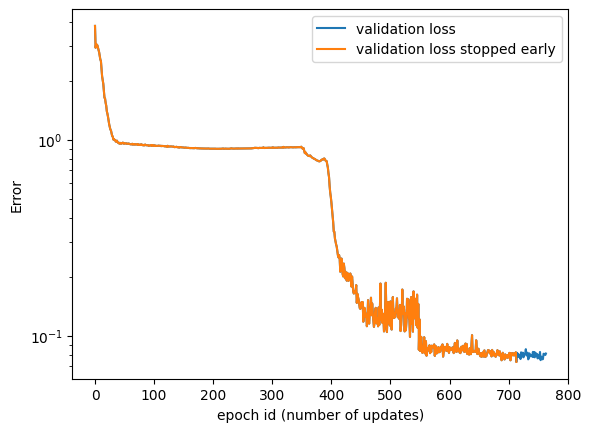

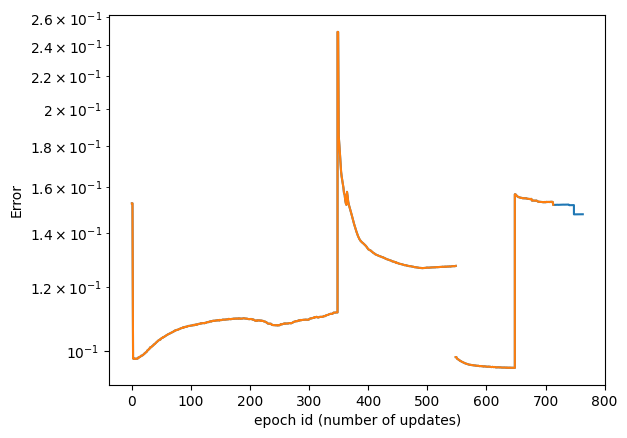

In [35]:
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss') 
#or use fit_sys_ss_enc.epoch_id for epochs

plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')

fit_sys.checkpoint_load_system('_best')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss stopped early')
plt.legend()
plt.show()


fit_sys.checkpoint_load_system('_last')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_train**0.5,label='train sqrt loss')
fit_sys.checkpoint_load_system('_best')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_train**0.5,label='train sqrt loss stopped early')
plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')
plt.show()


In [36]:
def NRMS(x_true, x_pred):
    rms = np.sqrt(np.mean((x_true-x_pred)**2, axis=0))
    return rms, rms/np.std(x_true, axis=0)

In [37]:
arrow_sim_enc = fit_sys.apply_experiment(test_arrow_full)
print("set 1")
arrow_sim_enc_no_ext = fit_sys.apply_experiment(test_arrow_no_extrapolation)
print("set 2")
test_sim_enc = fit_sys.apply_experiment(test_multisine)
print("set 3")

set 1
set 2
set 3


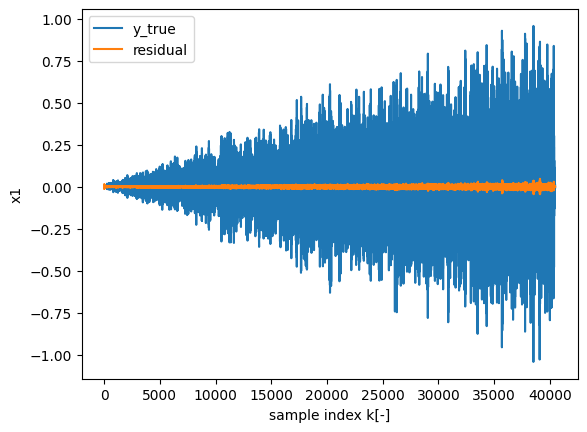

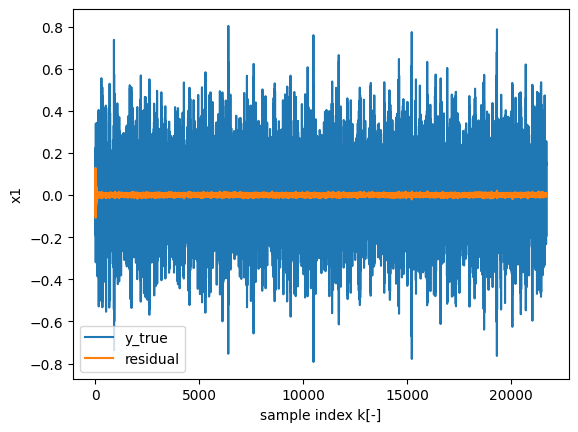

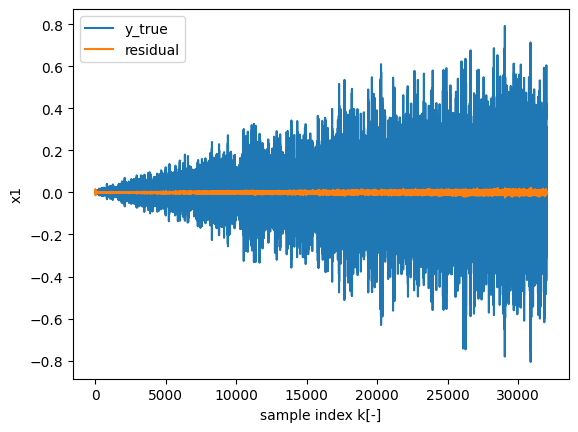

test sets NRMS/RMS 
 arrow full: (0.027414946427457627, 0.005087462684994657)
 multisine: (0.029281738655864496, 0.005518191757793888)
 arrow no ext: (0.027214444951972894, 0.004060720156266593)


In [38]:
plt.plot(test_arrow_full.y)
plt.plot(test_arrow_full.y-arrow_sim_enc.y)
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
NRMS_af = arrow_sim_enc.NRMS(test_arrow_full)
RMS_af  = arrow_sim_enc.RMS(test_arrow_full)

plt.plot(test_multisine.y)
plt.plot(test_multisine.y-test_sim_enc.y)
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
NRMS_tm = test_sim_enc.NRMS(test_multisine)
RMS_tm  = test_sim_enc.RMS(test_multisine)

plt.plot(test_arrow_no_extrapolation.y)
plt.plot(test_arrow_no_extrapolation.y-arrow_sim_enc_no_ext.y)
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.show()
NRMS_ae = arrow_sim_enc_no_ext.NRMS(test_arrow_no_extrapolation)
RMS_ae  = arrow_sim_enc_no_ext.RMS(test_arrow_no_extrapolation)

print(f'test sets NRMS/RMS \n arrow full: ({NRMS_af}, {RMS_af})\n multisine: ({NRMS_tm}, {RMS_tm})\n arrow no ext: ({NRMS_ae}, {RMS_ae})')

In [40]:
from nonlinear_benchmarks.error_metrics import RMSE

n = 50

test_multisine_RMSE = 1000*RMSE(test_multisine.y[n:], test_sim_enc.y[n:])
test_arrow_full_RMSE = 1000*RMSE(test_arrow_full.y[n:], arrow_sim_enc.y[n:])
test_arrow_no_extrapolation_RMSE = 1000*RMSE(test_arrow_no_extrapolation.y[n:], arrow_sim_enc_no_ext.y[n:])

print(f'{test_multisine_RMSE = :.3f} mV')
print(f'{test_arrow_full_RMSE = :.3f} mV')
print(f'{test_arrow_no_extrapolation_RMSE = :.3f} mV')

# unscaled
print(f'RMSE to submit = [{(1/T[0,0])**0.5*test_multisine_RMSE:.3f}; {(1/T[0,0])**0.5*test_arrow_full_RMSE:.3f}; {(1/T[0,0])**0.5*test_arrow_no_extrapolation_RMSE:.3f}]')

test_multisine_RMSE = 4.833 mV
test_arrow_full_RMSE = 5.085 mV
test_arrow_no_extrapolation_RMSE = 4.055 mV
RMSE to submit = [2.594; 2.729; 2.176]


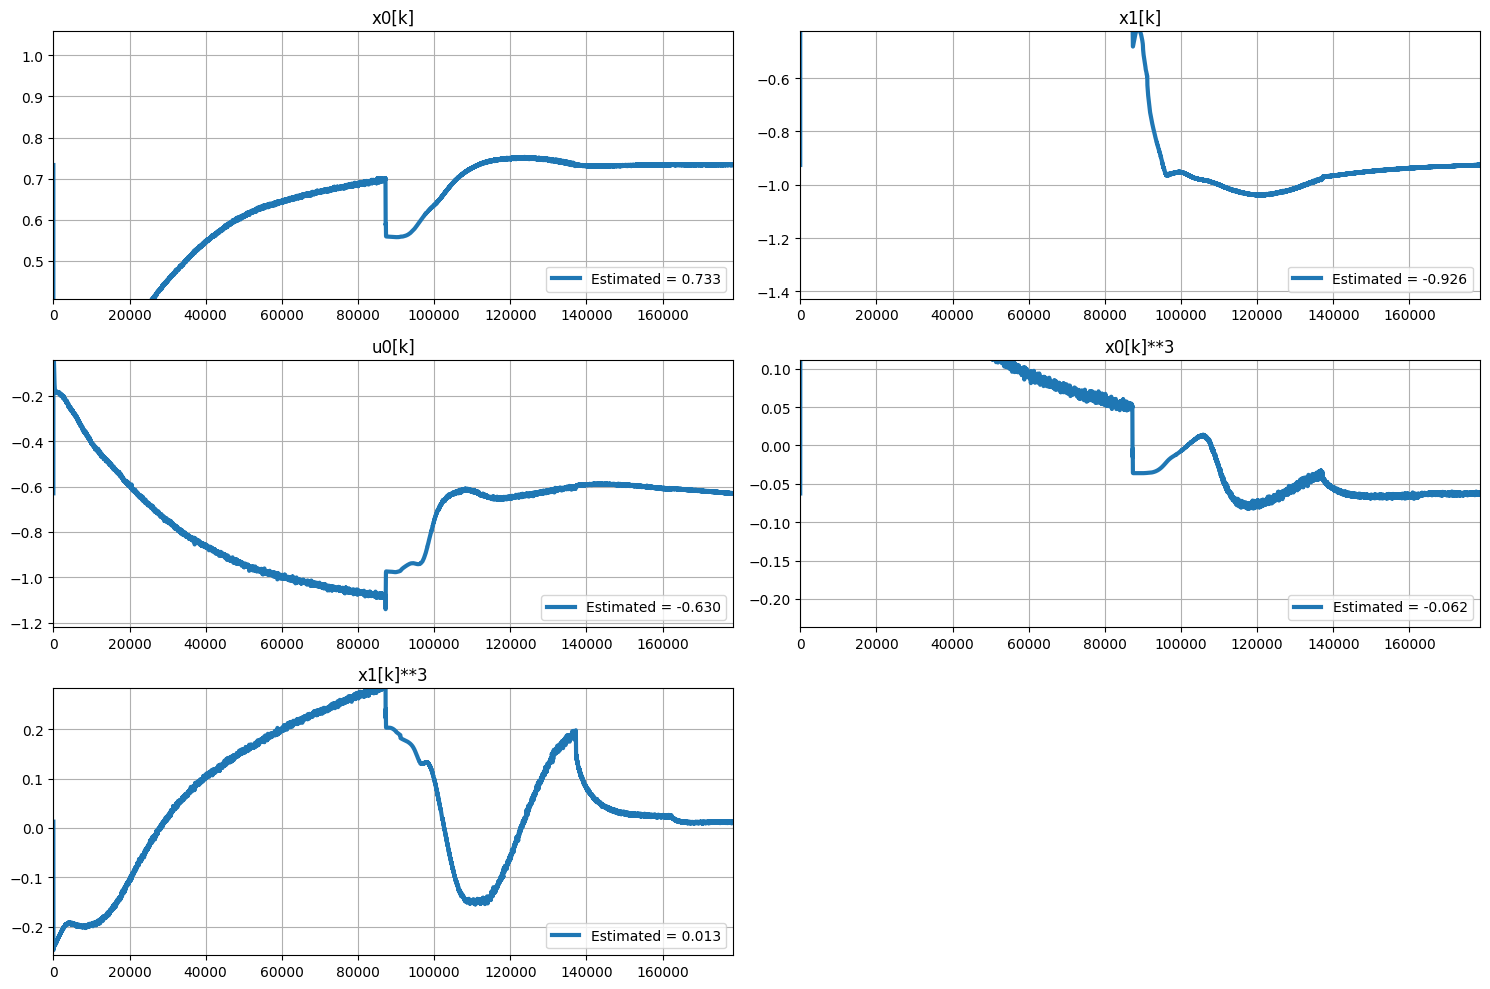

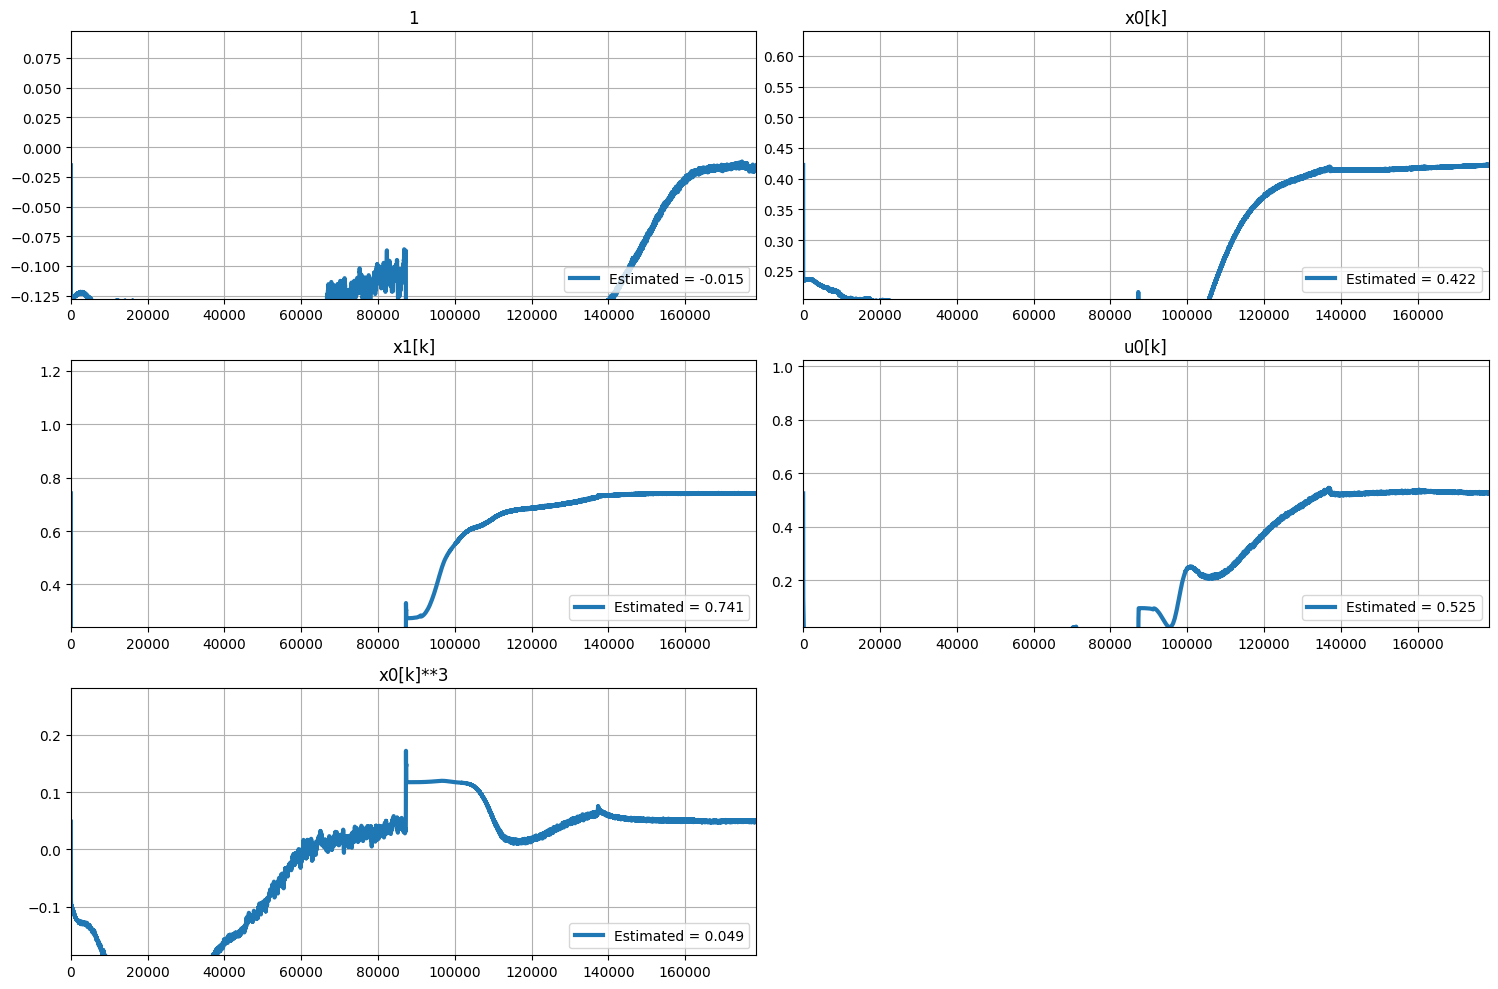

In [42]:
coeff = fit_sys.coefficients
coeff = np.array(coeff).T
plot_coeff_grid(coeff, states=2, labels=poly.feature_names, save=False, precision=3, threshold=0.01)